In [348]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings                  #워닝 메시지
warnings.filterwarnings('ignore')
# 그래프에서 한글 깨짐 방지
import platform

if platform.system() == "Darwin":          # MAC인 경우
    plt.rc('font', family ="AppleGothic")
else:
    plt.rc('font',family='Malgun Gothic')

#멧플로립에서 음수를 표시
plt.rc('axes',unicode_minus=False)



---
- train-test split (2.3 / 7.7)

In [349]:
df=pd.read_csv('./Dataset/분리전_외감.csv',index_col=False, encoding='euc-kr')

In [350]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test= train_test_split(df.drop('t-1감사의견코드',axis=1),df['t-1감사의견코드'],test_size=0.23,stratify=df['t-1감사의견코드'],random_state=0) 

In [351]:
train_data = pd.concat([X_train,y_train], axis=1)
train_data.drop('평균부채비율초과여부',axis=1,inplace=True)

In [352]:
test_data= pd.concat([X_test,y_test],axis=1 )
test_data.drop('평균부채비율초과여부',axis=1,inplace=True)

#### 

In [353]:
train_data['자산총계(천원)'] = train_data['자산총계(천원)'] * 1000
train_data['log자산총계'] = np.log(train_data['자산총계(천원)'])

test_data['자산총계(천원)'] = test_data['자산총계(천원)'] * 1000
test_data['log자산총계'] = np.log(test_data['자산총계(천원)'])

In [354]:
# # 데이터프레임에서 '이자보상배율' 열의 1퍼센트 절사평균과 표준편차 계산
# def trimmed_mean_1(x):
#     trim_pct = 0.1
#     lower_bound = np.percentile(x, trim_pct * 100)
#     upper_bound = np.percentile(x, (1 - trim_pct) * 100)
#     trimmed_values = x[(x >= lower_bound) & (x <= upper_bound)]
#     return trimmed_values.mean()

# def trimmed_std_1(x):
#     trim_pct = 0.1
#     lower_bound = np.percentile(x, trim_pct * 100)
#     upper_bound = np.percentile(x, (1 - trim_pct) * 100)
#     trimmed_values = x[(x >= lower_bound) & (x <= upper_bound)]
#     return trimmed_values.std()

# train_data['평균이보배'] = train_data.groupby(['산업분류', 'Year'])['이자보상배율'].transform(trimmed_mean_1)
# train_data['이보배S.E'] = train_data.groupby(['산업분류', 'Year'])['이자보상배율'].transform(trimmed_std_1)

# # 개별 이자보상배율과 평균-표준편차를 비교하여 이보배초과여부 계산
# train_data['이보배초과여부'] = np.where(train_data['이자보상배율'] < (train_data['평균이보배'] - 10*train_data['이보배S.E']), 1, 0)


In [355]:
# 1퍼센트 절사평균 계산 함수
def trimmed_mean_1(x):
    trim_pct = 0.05
    lower_bound = np.percentile(x, trim_pct * 100)
    upper_bound = np.percentile(x, (1 - trim_pct) * 100)
    trimmed_values = x[(x >= lower_bound) & (x <= upper_bound)]
    return trimmed_values.mean()

# 1퍼센트 절사표준편차 계산 함수
def trimmed_std_1(x):
    trim_pct = 0.05
    lower_bound = np.percentile(x, trim_pct * 100)
    upper_bound = np.percentile(x, (1 - trim_pct) * 100)
    trimmed_values = x[(x >= lower_bound) & (x <= upper_bound)]
    return trimmed_values.std()


---
# 1.파생이자보상배율

In [356]:

# train_data에서 산업분류와 연도별로 평균과 표준편차를 계산하여 딕셔너리로 저장
mean_std_dict = train_data.groupby(['산업분류', 'Year'])['이자보상배율'].agg([('평균이보배', trimmed_mean_1), ('이보배S.E', trimmed_std_1)]).reset_index()

# 표준편차를 그룹바이된 개수로 나누는 함수 추가
def divide_by_group_size(x):
    return x / x.count()

# train_data에서 그룹바이된 개수로 이보배 S.E를 나누어 '이보배S.E' 컬럼 생성
train_data['이보배S.E'] = train_data.groupby(['산업분류', 'Year'])['이자보상배율'].transform(trimmed_std_1) / train_data.groupby(['산업분류', 'Year'])['이자보상배율'].transform(divide_by_group_size)

# test_data에서도 그룹바이된 개수로 이보배 S.E를 나누도록 업데이트
test_data['이보배S.E'] = test_data.groupby(['산업분류', 'Year'])['이자보상배율'].transform(trimmed_std_1) / test_data.groupby(['산업분류', 'Year'])['이자보상배율'].transform(divide_by_group_size)

# train_data에서 '평균이보배'와 '이보배초과여부' 컬럼 생성
def apply_mean_std(row):
    industry = row['산업분류']
    year = row['Year']
    mean_val = mean_std_dict[(mean_std_dict['산업분류'] == industry) & (mean_std_dict['Year'] == year)]['평균이보배'].iloc[0]
    std_val = mean_std_dict[(mean_std_dict['산업분류'] == industry) & (mean_std_dict['Year'] == year)]['이보배S.E'].iloc[0]
    return pd.Series([mean_val, std_val])

train_data[['평균이보배', '이보배S.E']] = train_data.apply(apply_mean_std, axis=1)
test_data[['평균이보배', '이보배S.E']] = test_data.apply(apply_mean_std, axis=1)

# 개별 이자보상배율과 평균-표준편차를 비교하여 '이보배초과여부' 컬럼 생성
train_data['이보배초과여부'] = np.where(train_data['이자보상배율'] < (train_data['평균이보배'] - 1.28*train_data['이보배S.E']), 1, 0)
test_data['이보배초과여부'] = np.where(test_data['이자보상배율'] < (test_data['평균이보배'] - 1.28*test_data['이보배S.E']), 1, 0)





In [357]:
train_data[['회사명','거래소코드','산업분류','Year','이자보상배율', '평균이보배', '이보배S.E','이보배초과여부']].head(50)

,회사명,거래소코드,산업분류,Year,이자보상배율,평균이보배,이보배S.E,이보배초과여부
155540,주식회사라이프시맨틱스,86822,정보통신업,2018,-13.357516,1326.056999,2478.058807,0
47457,부산탱크터미널(주),42140,운수 및 창고업,2020,8.709388,521.479504,1646.889456,0
94639,주식회사덴츠엑스,60552,"전문, 과학 및 기술 서비스업",2019,-198.699143,1029.991860,2233.753039,0
147801,주식회사시영,81934,"전문, 과학 및 기술 서비스업",2016,14.620331,1631.859329,2658.921958,0
136830,주식회사골든트리,76348,부동산업,2016,13.221831,506.039742,1648.854681,0
32508,엔이케이(주),27320,제조업,2017,6057.061304,496.661932,1593.679221,0
150666,에스제이대명(주),83348,부동산업,2020,-0.480974,342.460123,1372.212085,0
148491,(주)굿데이,82258,부동산업,2019,0.088081,382.332179,1450.159481,0
9018,(주)문영건설,14611,건설업,2012,-3.475501,472.082765,1551.262446,0
137467,농업회사법인우일팜주식회사,76590,"농업, 임업 및 어업",2015,-198.699143,-14.657749,63.827846,1


In [358]:
test_data[['회사명','거래소코드','산업분류','Year','이자보상배율', '평균이보배','이보배S.E', '이보배초과여부']].head(50)

,회사명,거래소코드,산업분류,Year,이자보상배율,평균이보배,이보배S.E,이보배초과여부
20572,주식회사신흥,18169,제조업,2018,6057.061304,467.670069,1561.523332,0
43360,서대산드림리조트주식회사,40710,숙박 및 음식점업,2013,0.011272,9.278328,36.321427,0
66113,주식회사남전상공,49091,도매 및 소매업,2017,22.383691,956.913714,2149.299553,0
100160,신일산업(주),61703,제조업,2016,-7.268280,482.080054,1567.455576,0
28051,주식회사녹수,20695,제조업,2020,286.723907,466.914520,1541.966699,0
162924,(주)청강도시개발,91686,부동산업,2018,-0.967963,409.561203,1517.535933,0
56997,주식회사나이아가라관광,45953,숙박 및 음식점업,2018,-0.348306,2.217632,14.933219,0
147764,(주)제이더블유와이,81918,부동산업,2019,1.458579,382.332179,1450.159481,0
79692,(주)현우,53896,부동산업,2012,0.345265,614.847118,1832.114001,0
110892,(주)셀인바이오,65235,제조업,2018,12.561726,467.670069,1561.523332,0


In [359]:
train_data['이보배초과여부'].value_counts()


이보배초과여부
0    137028
1       650
Name: count, dtype: int64

In [360]:
train_data[train_data['이보배초과여부']==1]['t-1감사의견코드'].value_counts()

t-1감사의견코드
0.0    615
1.0     35
Name: count, dtype: int64

---
# 2. 파부비

In [361]:

# train_data에서 산업분류와 연도별로 평균과 표준편차를 계산하여 딕셔너리로 저장
mean_std_dict = train_data.groupby(['산업분류', 'Year'])['부채비율'].agg([('평균파부비', trimmed_mean_1), ('파부비S.E', trimmed_std_1)]).reset_index()

# 표준편차를 그룹바이된 개수로 나누는 함수 추가
def divide_by_group_size(x):
    return x / x.count()

# train_data에서 그룹바이된 개수로 이보배 S.E를 나누어 '파부비S.E' 컬럼 생성
train_data['파부비S.E'] = train_data.groupby(['산업분류', 'Year'])['부채비율'].transform(trimmed_std_1) / train_data.groupby(['산업분류', 'Year'])['부채비율'].transform(divide_by_group_size)

# test_data에서도 그룹바이된 개수로 이보배 S.E를 나누도록 업데이트
test_data['파부비S.E'] = test_data.groupby(['산업분류', 'Year'])['부채비율'].transform(trimmed_std_1) / test_data.groupby(['산업분류', 'Year'])['부채비율'].transform(divide_by_group_size)

# train_data에서 '평균파부비'와 '이보배초과여부' 컬럼 생성
def apply_mean_std(row):
    industry = row['산업분류']
    year = row['Year']
    mean_val = mean_std_dict[(mean_std_dict['산업분류'] == industry) & (mean_std_dict['Year'] == year)]['평균파부비'].iloc[0]
    std_val = mean_std_dict[(mean_std_dict['산업분류'] == industry) & (mean_std_dict['Year'] == year)]['파부비S.E'].iloc[0]
    return pd.Series([mean_val, std_val])

train_data[['평균파부비', '파부비S.E']] = train_data.apply(apply_mean_std, axis=1)
test_data[['평균파부비', '파부비S.E']] = test_data.apply(apply_mean_std, axis=1)

# 개별 부채비율과 평균-표준편차를 비교하여 '이보배초과여부' 컬럼 생성
train_data['파부비초과여부'] = np.where(train_data['부채비율'] > (train_data['평균파부비'] + 1.28*train_data['파부비S.E']), 1, 0)
test_data['파부비초과여부'] = np.where(test_data['부채비율'] > (test_data['평균파부비'] + 1.28*test_data['파부비S.E']), 1, 0)


In [362]:
train_data[['회사명','거래소코드','산업분류','Year','부채비율', '평균파부비', '파부비S.E','파부비초과여부']].head(50)

,회사명,거래소코드,산업분류,Year,부채비율,평균파부비,파부비S.E,파부비초과여부
155540,주식회사라이프시맨틱스,86822,정보통신업,2018,1251.02,119.877898,157.200679,1
47457,부산탱크터미널(주),42140,운수 및 창고업,2020,107.19,221.395962,278.132839,0
94639,주식회사덴츠엑스,60552,"전문, 과학 및 기술 서비스업",2019,399.11,153.483980,179.579841,1
147801,주식회사시영,81934,"전문, 과학 및 기술 서비스업",2016,267.34,129.180900,187.603133,0
136830,주식회사골든트리,76348,부동산업,2016,390.03,661.061862,1084.799911,0
32508,엔이케이(주),27320,제조업,2017,20.98,177.230902,161.289563,0
150666,에스제이대명(주),83348,부동산업,2020,0.00,734.269445,1241.445485,0
148491,(주)굿데이,82258,부동산업,2019,173.76,661.281003,1102.253153,0
9018,(주)문영건설,14611,건설업,2012,0.00,289.526118,427.417604,0
137467,농업회사법인우일팜주식회사,76590,"농업, 임업 및 어업",2015,120.27,123.582031,132.978462,0


In [363]:
test_data[['회사명','거래소코드','산업분류','Year','부채비율', '평균파부비', '파부비S.E','파부비초과여부']].head(50)

,회사명,거래소코드,산업분류,Year,부채비율,평균파부비,파부비S.E,파부비초과여부
20572,주식회사신흥,18169,제조업,2018,42.39,174.159880,161.009684,0
43360,서대산드림리조트주식회사,40710,숙박 및 음식점업,2013,189.47,257.375404,386.668417,0
66113,주식회사남전상공,49091,도매 및 소매업,2017,31.60,217.036091,242.039599,0
100160,신일산업(주),61703,제조업,2016,140.95,180.197145,158.158844,0
28051,주식회사녹수,20695,제조업,2020,26.35,164.971576,144.125459,0
162924,(주)청강도시개발,91686,부동산업,2018,0.00,648.968362,1042.192205,0
56997,주식회사나이아가라관광,45953,숙박 및 음식점업,2018,139.26,399.688711,687.974110,0
147764,(주)제이더블유와이,81918,부동산업,2019,311.29,661.281003,1102.253153,0
79692,(주)현우,53896,부동산업,2012,0.00,574.868158,946.124850,0
110892,(주)셀인바이오,65235,제조업,2018,33.73,174.159880,161.009684,0


In [364]:
train_data['파부비초과여부'].value_counts()

파부비초과여부
0    117751
1     19927
Name: count, dtype: int64

In [365]:
train_data[train_data['파부비초과여부']==1]['t-1감사의견코드'].value_counts()

t-1감사의견코드
0.0    17085
1.0     2842
Name: count, dtype: int64

---
# 3.파당비


In [366]:

# train_data에서 산업분류와 연도별로 평균과 표준편차를 계산하여 딕셔너리로 저장
mean_std_dict = train_data.groupby(['산업분류', 'Year'])['당좌비율'].agg([('평균파당비', trimmed_mean_1), ('파당비S.E', trimmed_std_1)]).reset_index()

# 표준편차를 그룹바이된 개수로 나누는 함수 추가
def divide_by_group_size(x):
    return x / x.count()

# train_data에서 그룹바이된 개수로 이보배 S.E를 나누어 '파당비S.E' 컬럼 생성
train_data['파당비S.E'] = train_data.groupby(['산업분류', 'Year'])['당좌비율'].transform(trimmed_std_1) / train_data.groupby(['산업분류', 'Year'])['당좌비율'].transform(divide_by_group_size)

# test_data에서도 그룹바이된 개수로 이보배 S.E를 나누도록 업데이트
test_data['파당비S.E'] = test_data.groupby(['산업분류', 'Year'])['당좌비율'].transform(trimmed_std_1) / test_data.groupby(['산업분류', 'Year'])['당좌비율'].transform(divide_by_group_size)

# train_data에서 '평균파당비'와 '이보배초과여부' 컬럼 생성
def apply_mean_std(row):
    industry = row['산업분류']
    year = row['Year']
    mean_val = mean_std_dict[(mean_std_dict['산업분류'] == industry) & (mean_std_dict['Year'] == year)]['평균파당비'].iloc[0]
    std_val = mean_std_dict[(mean_std_dict['산업분류'] == industry) & (mean_std_dict['Year'] == year)]['파당비S.E'].iloc[0]
    return pd.Series([mean_val, std_val])

train_data[['평균파당비', '파당비S.E']] = train_data.apply(apply_mean_std, axis=1)
test_data[['평균파당비', '파당비S.E']] = test_data.apply(apply_mean_std, axis=1)

# 개별 당좌비율과 평균-표준편차를 비교하여 '이보배초과여부' 컬럼 생성
train_data['파당비초과여부'] = np.where(train_data['당좌비율'] < (train_data['평균파당비'] - 1.28*train_data['파당비S.E']), 1, 0)
test_data['파당비초과여부'] = np.where(test_data['당좌비율'] < (test_data['평균파당비'] - 1.28*test_data['파당비S.E']), 1, 0)


In [367]:
train_data[['회사명','거래소코드','산업분류','Year','당좌비율', '평균파당비', '파당비S.E','파당비초과여부']].head(50)

,회사명,거래소코드,산업분류,Year,당좌비율,평균파당비,파당비S.E,파당비초과여부
155540,주식회사라이프시맨틱스,86822,정보통신업,2018,347.96,259.385725,282.348094,0
47457,부산탱크터미널(주),42140,운수 및 창고업,2020,68.72,97.895064,80.896277,0
94639,주식회사덴츠엑스,60552,"전문, 과학 및 기술 서비스업",2019,109.86,206.145857,192.413658,0
147801,주식회사시영,81934,"전문, 과학 및 기술 서비스업",2016,55.31,267.663959,346.788092,0
136830,주식회사골든트리,76348,부동산업,2016,30.73,111.868806,187.434443,0
32508,엔이케이(주),27320,제조업,2017,349.32,116.035343,104.958182,0
150666,에스제이대명(주),83348,부동산업,2020,18.93,107.683562,161.742307,0
148491,(주)굿데이,82258,부동산업,2019,70.19,102.416252,147.214123,0
9018,(주)문영건설,14611,건설업,2012,45.26,165.856970,135.926401,0
137467,농업회사법인우일팜주식회사,76590,"농업, 임업 및 어업",2015,40.70,144.487500,272.270064,0


In [368]:
test_data[['회사명','거래소코드','산업분류','Year','당좌비율', '평균파당비', '파당비S.E','파당비초과여부']].head(50)

,회사명,거래소코드,산업분류,Year,당좌비율,평균파당비,파당비S.E,파당비초과여부
20572,주식회사신흥,18169,제조업,2018,256.29,117.174637,108.567389,0
43360,서대산드림리조트주식회사,40710,숙박 및 음식점업,2013,0.34,67.832032,98.762649,0
66113,주식회사남전상공,49091,도매 및 소매업,2017,171.57,128.067361,118.493494,0
100160,신일산업(주),61703,제조업,2016,92.88,115.177623,99.798183,0
28051,주식회사녹수,20695,제조업,2020,229.57,118.362321,97.505021,0
162924,(주)청강도시개발,91686,부동산업,2018,190.59,113.140938,187.380006,0
56997,주식회사나이아가라관광,45953,숙박 및 음식점업,2018,13.12,54.055257,68.728277,0
147764,(주)제이더블유와이,81918,부동산업,2019,2.26,102.416252,147.214123,0
79692,(주)현우,53896,부동산업,2012,37.78,153.198274,354.681395,0
110892,(주)셀인바이오,65235,제조업,2018,177.35,117.174637,108.567389,0


In [369]:
train_data['파당비초과여부'].value_counts()

파당비초과여부
0    136912
1       766
Name: count, dtype: int64

In [370]:
train_data[train_data['파당비초과여부']==1]['t-1감사의견코드'].value_counts()

t-1감사의견코드
0.0    738
1.0     28
Name: count, dtype: int64

---
# 4.파차의

In [371]:

# train_data에서 산업분류와 연도별로 평균과 표준편차를 계산하여 딕셔너리로 저장
mean_std_dict = train_data.groupby(['산업분류', 'Year'])['차입금의존도'].agg([('평균파차의', trimmed_mean_1), ('파차의S.E', trimmed_std_1)]).reset_index()

# 표준편차를 그룹바이된 개수로 나누는 함수 추가
def divide_by_group_size(x):
    return x / x.count()

# train_data에서 그룹바이된 개수로 이보배 S.E를 나누어 '파차의S.E' 컬럼 생성
train_data['파차의S.E'] = train_data.groupby(['산업분류', 'Year'])['차입금의존도'].transform(trimmed_std_1) / train_data.groupby(['산업분류', 'Year'])['차입금의존도'].transform(divide_by_group_size)

# test_data에서도 그룹바이된 개수로 이보배 S.E를 나누도록 업데이트
test_data['파차의S.E'] = test_data.groupby(['산업분류', 'Year'])['차입금의존도'].transform(trimmed_std_1) / test_data.groupby(['산업분류', 'Year'])['차입금의존도'].transform(divide_by_group_size)

# train_data에서 '평균파차의'와 '이보배초과여부' 컬럼 생성
def apply_mean_std(row):
    industry = row['산업분류']
    year = row['Year']
    mean_val = mean_std_dict[(mean_std_dict['산업분류'] == industry) & (mean_std_dict['Year'] == year)]['평균파차의'].iloc[0]
    std_val = mean_std_dict[(mean_std_dict['산업분류'] == industry) & (mean_std_dict['Year'] == year)]['파차의S.E'].iloc[0]
    return pd.Series([mean_val, std_val])

train_data[['평균파차의', '파차의S.E']] = train_data.apply(apply_mean_std, axis=1)
test_data[['평균파차의', '파차의S.E']] = test_data.apply(apply_mean_std, axis=1)

# 개별 차입금의존도과 평균-표준편차를 비교하여 '이보배초과여부' 컬럼 생성
train_data['파차의초과여부'] = np.where(train_data['차입금의존도'] > (train_data['평균파차의'] + 1.28*train_data['파차의S.E']), 1, 0)
test_data['파차의초과여부'] = np.where(test_data['차입금의존도'] > (test_data['평균파차의'] + 1.28*test_data['파차의S.E']), 1, 0)


In [372]:
train_data[['회사명','거래소코드','산업분류','Year','차입금의존도', '평균파차의', '파차의S.E','파차의초과여부']].head(50)

,회사명,거래소코드,산업분류,Year,차입금의존도,평균파차의,파차의S.E,파차의초과여부
155540,주식회사라이프시맨틱스,86822,정보통신업,2018,6.09,17.821542,22.417656,0
47457,부산탱크터미널(주),42140,운수 및 창고업,2020,45.96,36.855182,28.150505,0
94639,주식회사덴츠엑스,60552,"전문, 과학 및 기술 서비스업",2019,0.00,20.237124,22.375037,0
147801,주식회사시영,81934,"전문, 과학 및 기술 서비스업",2016,70.59,19.072457,23.387205,1
136830,주식회사골든트리,76348,부동산업,2016,1.76,51.017897,31.285933,0
32508,엔이케이(주),27320,제조업,2017,0.00,32.596285,22.304121,0
150666,에스제이대명(주),83348,부동산업,2020,104.99,60.384886,29.980589,1
148491,(주)굿데이,82258,부동산업,2019,62.07,56.825830,30.581880,0
9018,(주)문영건설,14611,건설업,2012,99.45,30.326127,29.234716,1
137467,농업회사법인우일팜주식회사,76590,"농업, 임업 및 어업",2015,52.82,35.179375,25.819979,0


In [373]:
test_data[['회사명','거래소코드','산업분류','Year','차입금의존도', '평균파차의', '파차의S.E','파차의초과여부']].head(50)

,회사명,거래소코드,산업분류,Year,차입금의존도,평균파차의,파차의S.E,파차의초과여부
20572,주식회사신흥,18169,제조업,2018,0.00,32.762364,22.180846,0
43360,서대산드림리조트주식회사,40710,숙박 및 음식점업,2013,64.92,42.761667,30.203616,0
66113,주식회사남전상공,49091,도매 및 소매업,2017,0.00,25.602339,23.568095,0
100160,신일산업(주),61703,제조업,2016,18.77,32.707857,22.275232,0
28051,주식회사녹수,20695,제조업,2020,1.87,32.043097,21.784032,0
162924,(주)청강도시개발,91686,부동산업,2018,102.67,54.630152,31.630726,1
56997,주식회사나이아가라관광,45953,숙박 및 음식점업,2018,28.71,50.527979,31.124093,0
147764,(주)제이더블유와이,81918,부동산업,2019,73.03,56.825830,30.581880,0
79692,(주)현우,53896,부동산업,2012,16.47,47.641560,32.821707,0
110892,(주)셀인바이오,65235,제조업,2018,13.42,32.762364,22.180846,0


In [374]:
train_data['파차의초과여부'].value_counts()

파차의초과여부
0    115229
1     22449
Name: count, dtype: int64

In [375]:
train_data[train_data['파차의초과여부']==1]['t-1감사의견코드'].value_counts()

t-1감사의견코드
0.0    19327
1.0     3122
Name: count, dtype: int64

In [376]:
# # 차입금의존도 30% 이상 기업을 1(부실), 아니면 0(정상)

# train_data['차입금의존정도'] = 0

# for i in train_data.index :
#     if train_data['차입금의존도'][i] > 30 :
#         train_data['차입금의존정도'][i] = 1
#     else :
#         train_data['차입금의존정도'][i] = 0

In [377]:
# train_data['차입금의존정도'].value_counts()

In [378]:
# train_data[train_data['차입금의존정도']==1]['t-1감사의견코드'].value_counts()

---
# 5.파로이

In [379]:

# train_data에서 산업분류와 연도별로 평균과 표준편차를 계산하여 딕셔너리로 저장
mean_std_dict = train_data.groupby(['산업분류', 'Year'])['자기자본순이익률'].agg([('평균파로이', trimmed_mean_1), ('파로이S.E', trimmed_std_1)]).reset_index()

# 표준편차를 그룹바이된 개수로 나누는 함수 추가
def divide_by_group_size(x):
    return x / x.count()

# train_data에서 그룹바이된 개수로 이보배 S.E를 나누어 '파로이S.E' 컬럼 생성
train_data['파로이S.E'] = train_data.groupby(['산업분류', 'Year'])['자기자본순이익률'].transform(trimmed_std_1) / train_data.groupby(['산업분류', 'Year'])['자기자본순이익률'].transform(divide_by_group_size)

# test_data에서도 그룹바이된 개수로 이보배 S.E를 나누도록 업데이트
test_data['파로이S.E'] = test_data.groupby(['산업분류', 'Year'])['자기자본순이익률'].transform(trimmed_std_1) / test_data.groupby(['산업분류', 'Year'])['자기자본순이익률'].transform(divide_by_group_size)

# train_data에서 '평균파로이'와 '이보배초과여부' 컬럼 생성
def apply_mean_std(row):
    industry = row['산업분류']
    year = row['Year']
    mean_val = mean_std_dict[(mean_std_dict['산업분류'] == industry) & (mean_std_dict['Year'] == year)]['평균파로이'].iloc[0]
    std_val = mean_std_dict[(mean_std_dict['산업분류'] == industry) & (mean_std_dict['Year'] == year)]['파로이S.E'].iloc[0]
    return pd.Series([mean_val, std_val])

train_data[['평균파로이', '파로이S.E']] = train_data.apply(apply_mean_std, axis=1)
test_data[['평균파로이', '파로이S.E']] = test_data.apply(apply_mean_std, axis=1)

# 개별 자기자본순이익률과 평균-표준편차를 비교하여 '이보배초과여부' 컬럼 생성
train_data['파로이초과여부'] = np.where(train_data['자기자본순이익률'] < (train_data['평균파로이'] - 1.28*train_data['파로이S.E']), 1, 0)
test_data['파로이초과여부'] = np.where(test_data['자기자본순이익률'] < (test_data['평균파로이'] - 1.28*test_data['파로이S.E']), 1, 0)


In [380]:
train_data[['회사명','거래소코드','산업분류','Year','자기자본순이익률', '평균파로이', '파로이S.E','파로이초과여부']].head(50)

,회사명,거래소코드,산업분류,Year,자기자본순이익률,평균파로이,파로이S.E,파로이초과여부
155540,주식회사라이프시맨틱스,86822,정보통신업,2018,-1218.33,4.409123,20.236097,1
47457,부산탱크터미널(주),42140,운수 및 창고업,2020,13.81,5.969516,16.299139,0
94639,주식회사덴츠엑스,60552,"전문, 과학 및 기술 서비스업",2019,-12.57,9.871327,25.063121,0
147801,주식회사시영,81934,"전문, 과학 및 기술 서비스업",2016,66.76,9.878792,17.023328,0
136830,주식회사골든트리,76348,부동산업,2016,408.97,22.618201,44.628907,0
32508,엔이케이(주),27320,제조업,2017,7.19,7.512924,14.141518,0
150666,에스제이대명(주),83348,부동산업,2020,0.00,12.804535,40.060361,0
148491,(주)굿데이,82258,부동산업,2019,-4.61,10.237613,30.362085,0
9018,(주)문영건설,14611,건설업,2012,0.00,8.083219,15.313255,0
137467,농업회사법인우일팜주식회사,76590,"농업, 임업 및 어업",2015,-36.20,7.110167,19.191960,1


In [381]:
test_data[['회사명','거래소코드','산업분류','Year','자기자본순이익률', '평균파로이', '파로이S.E','파로이초과여부']].head(50)

,회사명,거래소코드,산업분류,Year,자기자본순이익률,평균파로이,파로이S.E,파로이초과여부
20572,주식회사신흥,18169,제조업,2018,6.20,6.593451,13.791985,0
43360,서대산드림리조트주식회사,40710,숙박 및 음식점업,2013,0.02,4.321070,14.543022,0
66113,주식회사남전상공,49091,도매 및 소매업,2017,-1.38,13.787804,17.474664,0
100160,신일산업(주),61703,제조업,2016,10.37,10.088467,13.994673,0
28051,주식회사녹수,20695,제조업,2020,13.10,7.297311,15.276012,0
162924,(주)청강도시개발,91686,부동산업,2018,0.00,14.002422,36.040341,0
56997,주식회사나이아가라관광,45953,숙박 및 음식점업,2018,-1.59,-2.643653,16.473867,0
147764,(주)제이더블유와이,81918,부동산업,2019,7.55,10.237613,30.362085,0
79692,(주)현우,53896,부동산업,2012,0.00,7.292917,21.978796,0
110892,(주)셀인바이오,65235,제조업,2018,7.91,6.593451,13.791985,0


In [382]:
train_data['파로이초과여부'].value_counts()

파로이초과여부
0    123611
1     14067
Name: count, dtype: int64

In [383]:
train_data[train_data['파로이초과여부']==1]['t-1감사의견코드'].value_counts()

t-1감사의견코드
0.0    12620
1.0     1447
Name: count, dtype: int64

In [384]:
train_data['t-1감사의견코드'].value_counts()

t-1감사의견코드
0.0    128076
1.0      9602
Name: count, dtype: int64

---

In [385]:
train_data_new= train_data.copy()

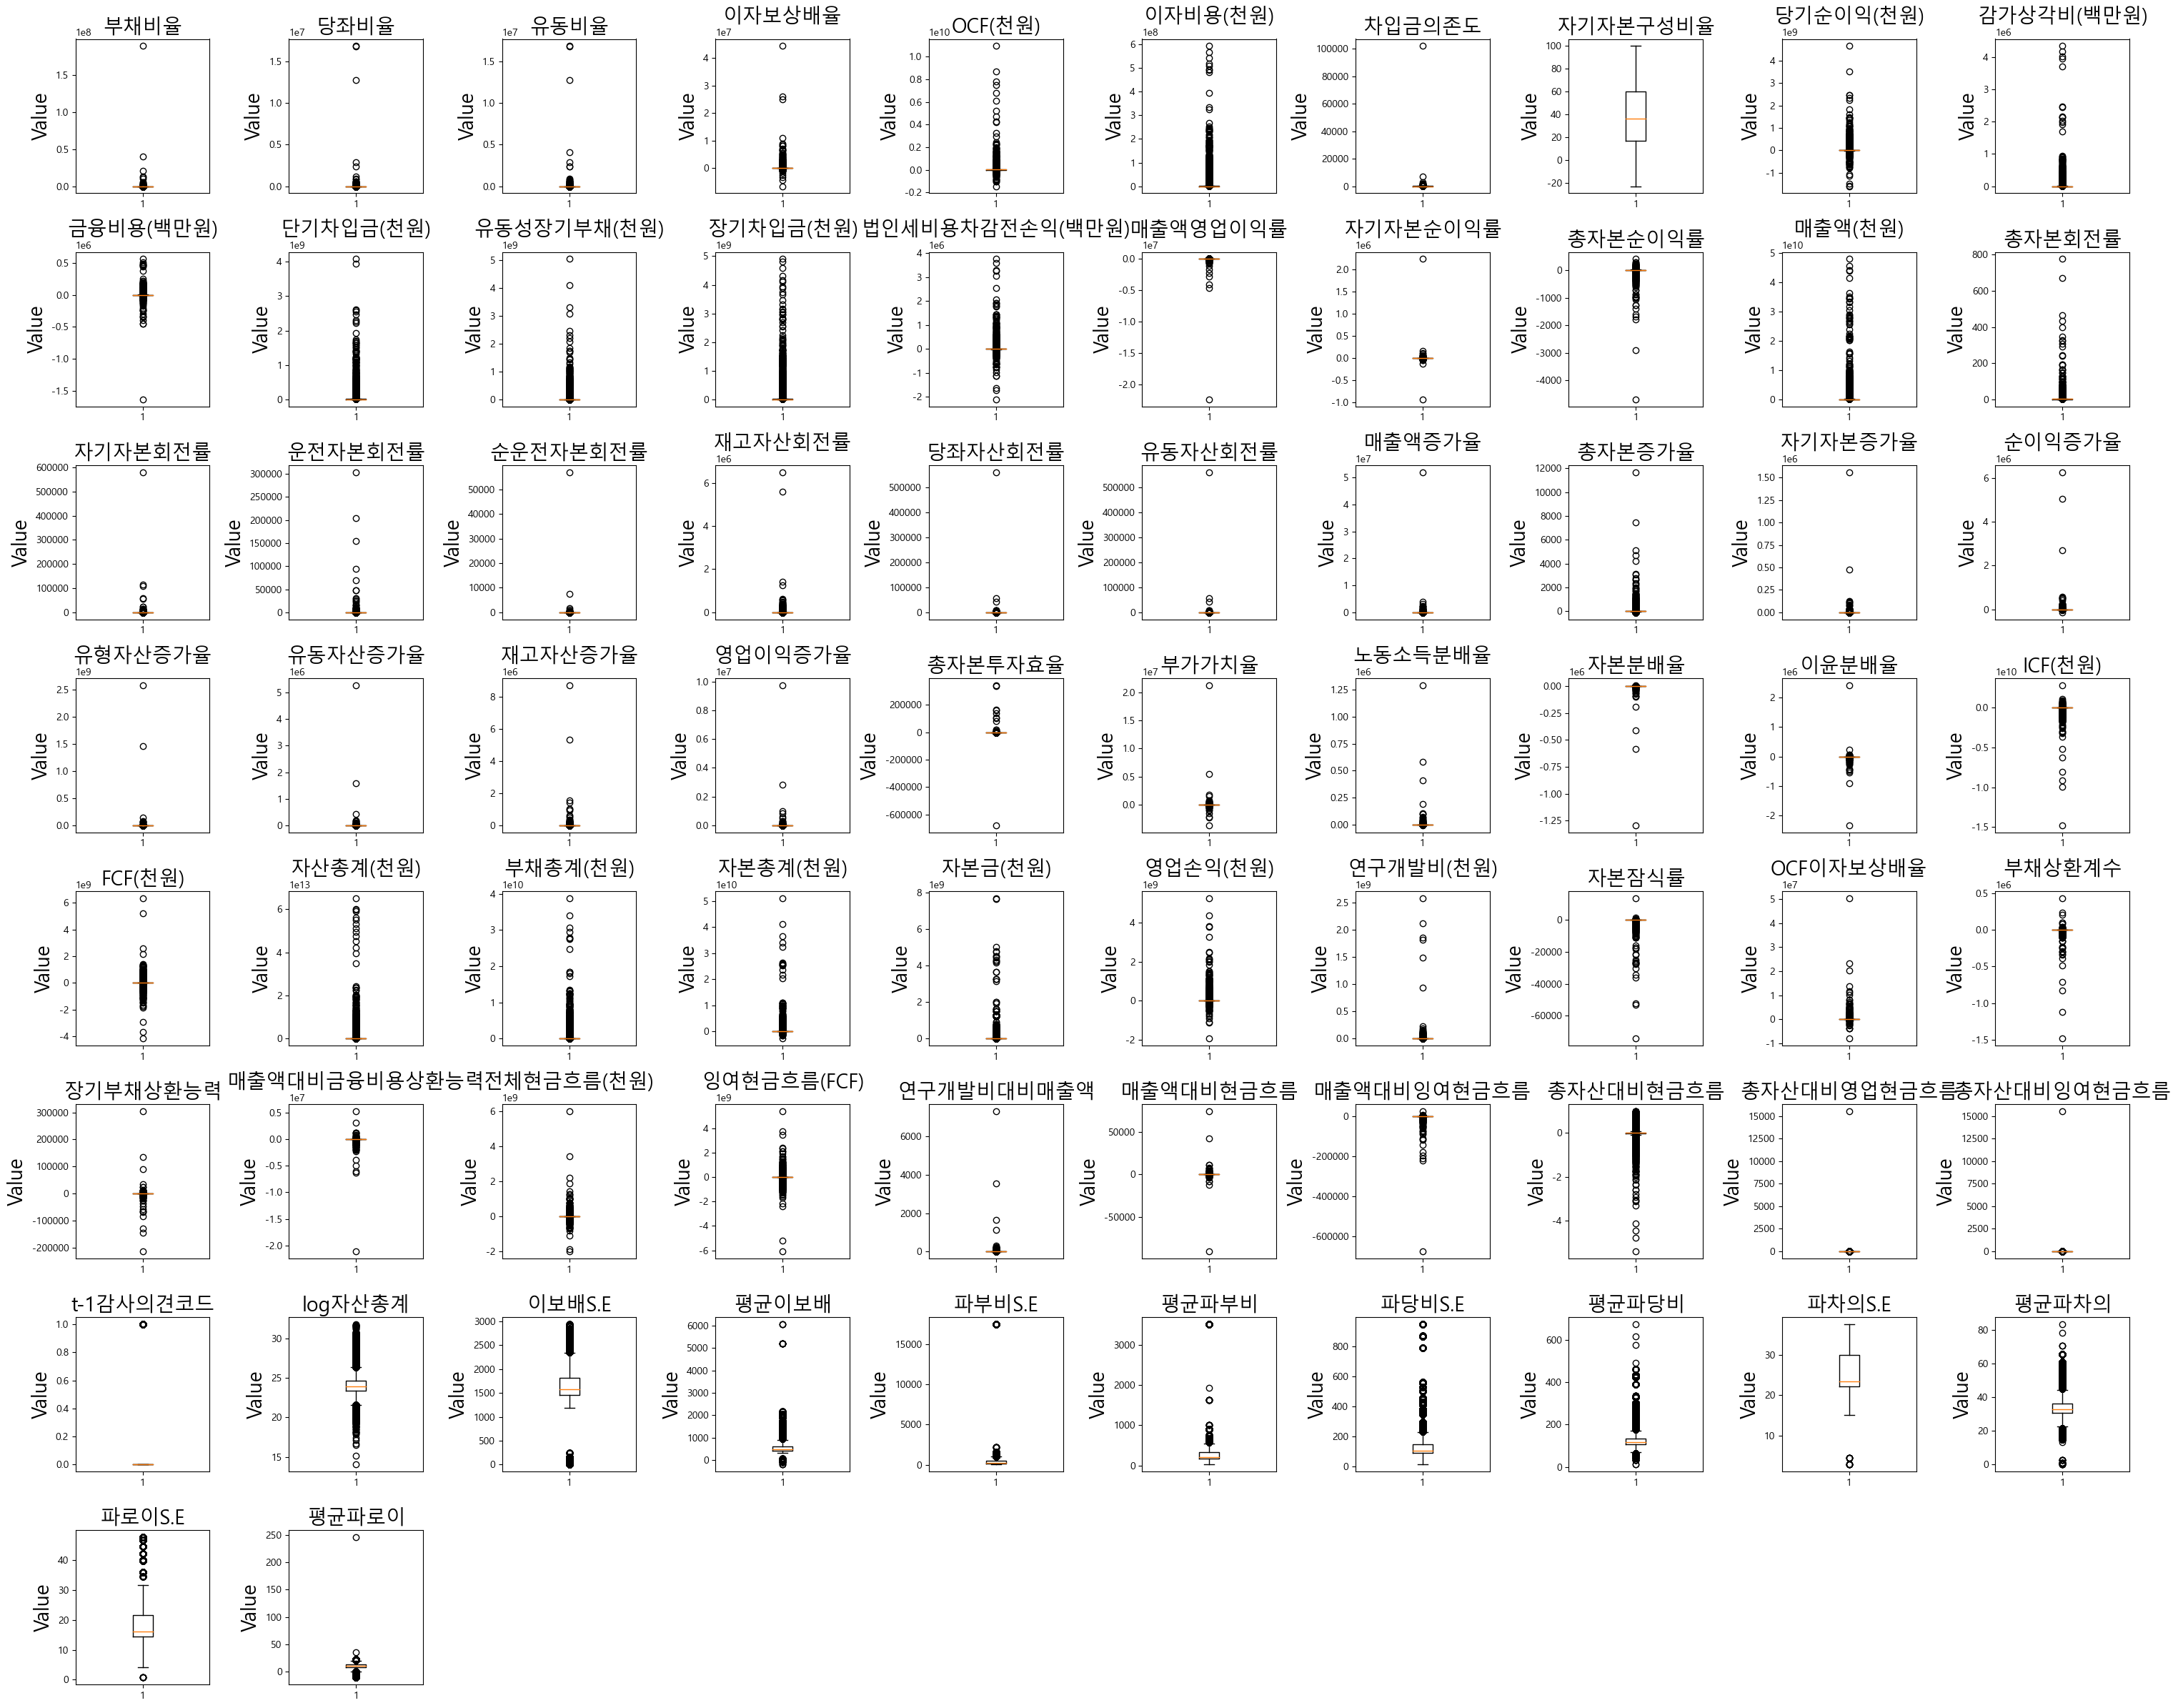

In [291]:
import matplotlib.pyplot as plt

df_수치_윈저라이징전 = train_data_new[train_data_new.select_dtypes(float).columns]
num_columns = len(df_수치_윈저라이징전.columns)

# 서브플롯의 크기 계산
nrows = (num_columns - 1) // 10 + 1
ncols = min(num_columns, 10)

# subplots로 boxplot 출력 (계산된 행과 열 개수로 서브플롯 그리기)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 24))

# 컬럼 개수에 따라 그려야 할 서브플롯의 개수만큼만 boxplot 그리기
for i, col in enumerate(df_수치_윈저라이징전):
    ax = axes[i // ncols, i % ncols]
    ax.boxplot(df_수치_윈저라이징전[col].dropna())
    ax.set_title(col, fontsize=20)  # 글씨 크기 설정
    ax.set_ylabel('Value', fontsize=20)  # 글씨 크기 설정

# 남은 서브플롯 삭제
for j in range(num_columns, nrows * ncols):
    fig.delaxes(axes.flatten()[j])  # 남은 서브플롯의 인덱스를 가져옴

plt.tight_layout()
plt.show()


In [292]:
# import numpy as np

# # 상하단 0.5% 값 구하기
# lower_bound = np.percentile(train_data_new['부채비율'], 0)
# upper_bound = np.percentile(train_data_new['부채비율'], 99.75)

# # 이상치 제거하여 새로운 DataFrame 생성
# df_cleaned = train_data_new[(train_data_new['부채비율'] >= lower_bound) & (train_data_new['부채비율'] <= upper_bound)]

# # 이상치를 지우기 전 DataFrame에서 해당 행 전체를 삭제
# train_data_new.drop(train_data_new.index.difference(df_cleaned.index), inplace=True)

In [293]:
train_data_new['t-1감사의견코드'].value_counts()

t-1감사의견코드
0.0    128076
1.0      9602
Name: count, dtype: int64

In [294]:
# from scipy.stats.mstats import winsorize
# ####                                                                       (하한, 상한)
# train_data_new['부채비율'] = winsorize(train_data_new['부채비율'], limits= (0, 0.01))
# train_data_new['당좌비율'] = winsorize(train_data_new['당좌비율'], limits= (0, 0.01))
# train_data_new['유동비율'] = winsorize(train_data_new['유동비율'], limits= (0, 0.01))
# train_data_new['이자보상배율'] = winsorize(train_data_new['이자보상배율'], limits= (0.002, 0.008))
# train_data_new['차입금의존도'] = winsorize(train_data_new['차입금의존도'], limits= (0, 0.01))
# train_data_new['매출액영업이익률'] = winsorize(train_data_new['매출액영업이익률'], limits= (0.01, 0))
# train_data_new['자기자본순이익률'] = winsorize(train_data_new['자기자본순이익률'], limits= (0.008, 0.002))
# train_data_new['총자본순이익률'] = winsorize(train_data_new['총자본순이익률'], limits= (0.01, 0))
# train_data_new['총자본회전률'] = winsorize(train_data_new['총자본회전률'], limits= (0, 0.01))
# train_data_new['자기자본회전률'] = winsorize(train_data_new['자기자본회전률'], limits= (0, 0.01))
# train_data_new['운전자본회전률'] = winsorize(train_data_new['운전자본회전률'], limits= (0, 0.01))
# train_data_new['순운전자본회전률'] = winsorize(train_data_new['순운전자본회전률'], limits= (0, 0.01))
# train_data_new['재고자산회전률'] = winsorize(train_data_new['재고자산회전률'], limits= (0, 0.01))

# train_data_new['당좌자산회전률'] = winsorize(train_data_new['당좌자산회전률'], limits= (0, 0.01))
# train_data_new['유동자산회전률'] = winsorize(train_data_new['유동자산회전률'], limits= (0, 0.01))
# train_data_new['매출액증가율'] = winsorize(train_data_new['매출액증가율'], limits= (0, 0.01))
# train_data_new['총자본증가율'] = winsorize(train_data_new['총자본증가율'], limits= (0, 0.01))
# train_data_new['자기자본증가율'] = winsorize(train_data_new['자기자본증가율'], limits= (0, 0.01))
# train_data_new['순이익증가율'] = winsorize(train_data_new['순이익증가율'], limits= (0, 0.01))
# train_data_new['유형자산증가율'] = winsorize(train_data_new['유형자산증가율'], limits= (0, 0.01))
# train_data_new['유동자산증가율'] = winsorize(train_data_new['유동자산증가율'], limits= (0, 0.01))
# train_data_new['재고자산증가율'] = winsorize(train_data_new['재고자산증가율'], limits= (0, 0.01))
# train_data_new['영업이익증가율'] = winsorize(train_data_new['영업이익증가율'], limits= (0, 0.01))

# train_data_new['총자본투자효율'] = winsorize(train_data_new['총자본투자효율'], limits= (0.001, 0.009))
# train_data_new['부가가치율'] = winsorize(train_data_new['부가가치율'], limits= (0.001, 0.009))
# train_data_new['총자본투자효율'] = winsorize(train_data_new['총자본투자효율'], limits= (0.008, 0.002))
# train_data_new['노동소득분배율'] = winsorize(train_data_new['노동소득분배율'], limits= (0, 0.01))
# train_data_new['자본분배율'] = winsorize(train_data_new['자본분배율'], limits= (0.01, 0))
# train_data_new['이윤분배율'] = winsorize(train_data_new['이윤분배율'], limits= (0.009, 0.001))
# train_data_new['파생이자보상배율'] = winsorize(train_data_new['파생이자보상배율'], limits= (0.003, 0.007))

# train_data_new['부채상환계수'] = winsorize(train_data_new['부채상환계수'], limits= (0.006, 0.004))
# train_data_new['장기/EBITDA'] = winsorize(train_data_new['장기/EBITDA'], limits= (0.005, 0.005))
# train_data_new['금융대비매출액'] = winsorize(train_data_new['금융대비매출액'], limits= (0.004, 0.006))
# train_data_new['연구개발비대비매출액'] = winsorize(train_data_new['연구개발비대비매출액'], limits= (0, 0.01))
# train_data_new['매출액대비현금흐름'] = winsorize(train_data_new['매출액대비현금흐름'], limits= (0.005, 0.005))
# train_data_new['총자산대비현금흐름'] = winsorize(train_data_new['총자산대비현금흐름'], limits= (0.006, 0.004))
# # train_data_new['총부채대비현금흐름'] = winsorize(train_data_new['총부채대비현금흐름'], limits= (0.007, 0.003))
# train_data_new['총자본대비현금흐름'] = winsorize(train_data_new['총자본대비현금흐름'], limits= (0.005, 0.005))
# train_data_new['총자본대비영업현금흐름'] = winsorize(train_data_new['총자본대비영업현금흐름'], limits= (0.004, 0.006))
# # train_data_new['총자산대비영업현금흐름'] = winsorize(train_data_new['총자산대비영업현금흐름'], limits= (0.00, 0.006))
# train_data_new['총부채대비영업현금흐름'] = winsorize(train_data_new['총부채대비영업현금흐름'], limits= (0.002, 0.008))


In [295]:
train_data_new= train_data.copy()
from scipy.stats.mstats import winsorize

- 부채비율

In [296]:
train_data_new['부채비율'] = winsorize(train_data_new['부채비율'], limits= (0, 0.005))  

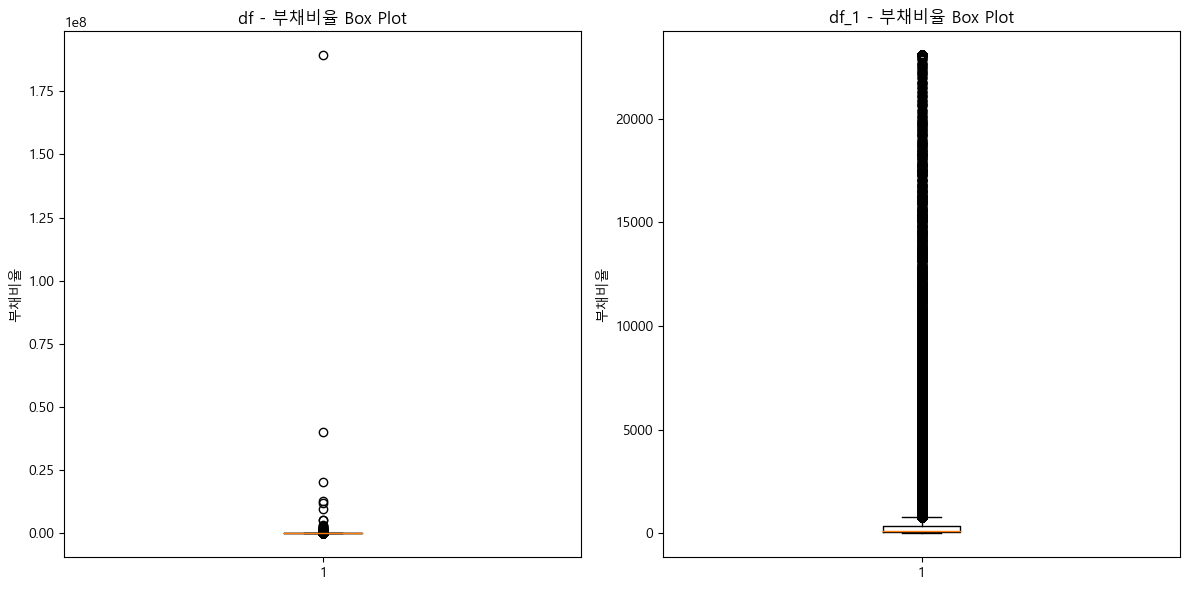

In [297]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['부채비율'].dropna())
axes[0].set_title('df - 부채비율 Box Plot')
axes[0].set_ylabel('부채비율')

# df_1['부채비율']의 박스플롯
axes[1].boxplot(train_data_new['부채비율'].dropna())
axes[1].set_title('df_1 - 부채비율 Box Plot')
axes[1].set_ylabel('부채비율')

# 그래프 간격 조정
plt.tight_layout()

# 그래프 출력
plt.show()

- 당좌비율

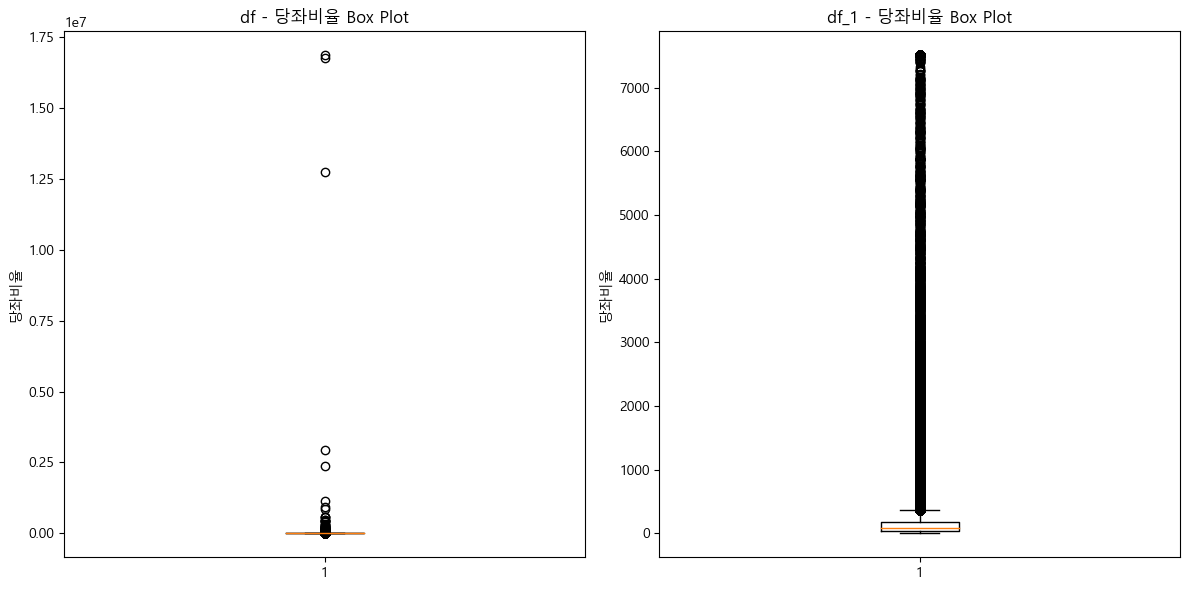

In [298]:
train_data_new= train_data.copy()

train_data_new['당좌비율'] = winsorize(train_data_new['당좌비율'], limits= (0, 0.005))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['당좌비율'].dropna())
axes[0].set_title('df - 당좌비율 Box Plot')
axes[0].set_ylabel('당좌비율')

# df_1['당좌비율']의 박스플롯
axes[1].boxplot(train_data_new['당좌비율'].dropna())
axes[1].set_title('df_1 - 당좌비율 Box Plot')
axes[1].set_ylabel('당좌비율')

# 그래프 간격 조정
plt.tight_layout()

# 그래프 

- 유동비율

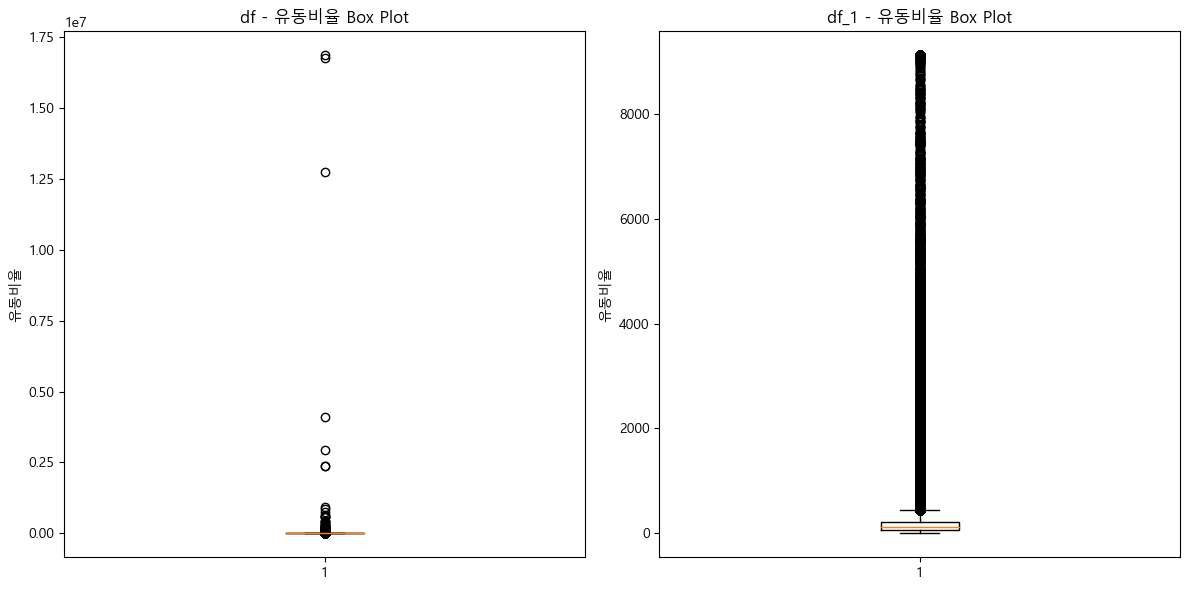

In [299]:
train_data_new= train_data.copy()

train_data_new['유동비율'] = winsorize(train_data_new['유동비율'], limits= (0, 0.005))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['유동비율'].dropna())
axes[0].set_title('df - 유동비율 Box Plot')
axes[0].set_ylabel('유동비율')

# df_1['유동비율']의 박스플롯
axes[1].boxplot(train_data_new['유동비율'].dropna())
axes[1].set_title('df_1 - 유동비율 Box Plot')
axes[1].set_ylabel('유동비율')

# 그래프 간격 조정
plt.tight_layout()

# 그래프 

- 이자보상배율

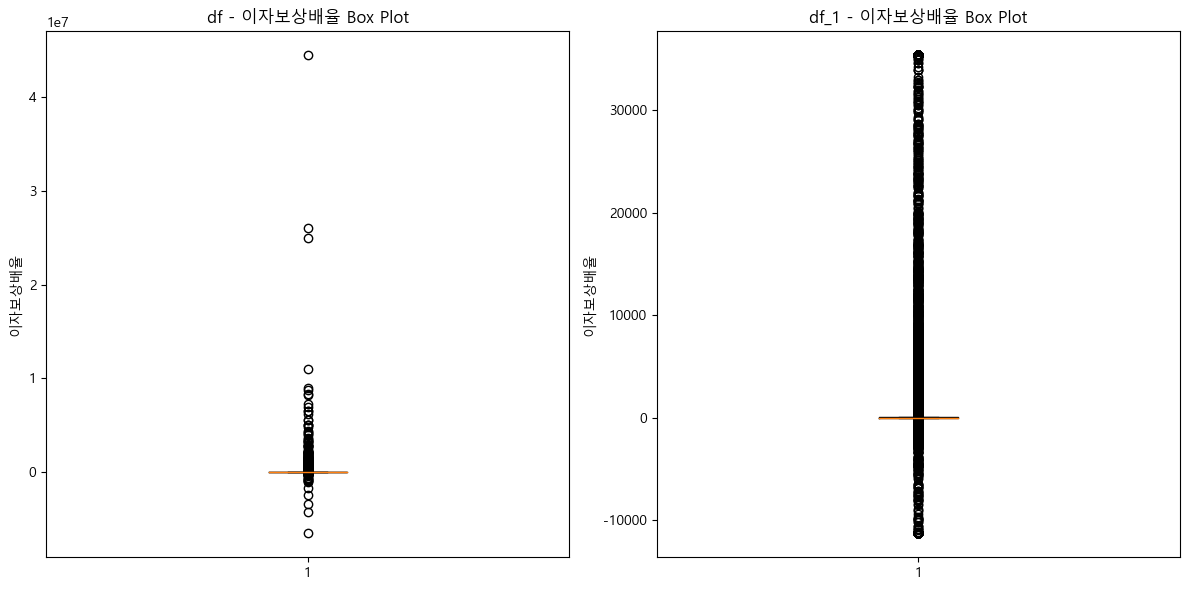

In [300]:
train_data_new= train_data.copy()

train_data_new['이자보상배율'] = winsorize(train_data_new['이자보상배율'], limits= (0.001, 0.004))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['이자보상배율'].dropna())
axes[0].set_title('df - 이자보상배율 Box Plot')
axes[0].set_ylabel('이자보상배율')

# df_1['이자보상배율']의 박스플롯
axes[1].boxplot(train_data_new['이자보상배율'].dropna())
axes[1].set_title('df_1 - 이자보상배율 Box Plot')
axes[1].set_ylabel('이자보상배율')

# 그래프 간격 조정
plt.tight_layout()

# 그래프 

- 차입금의존도

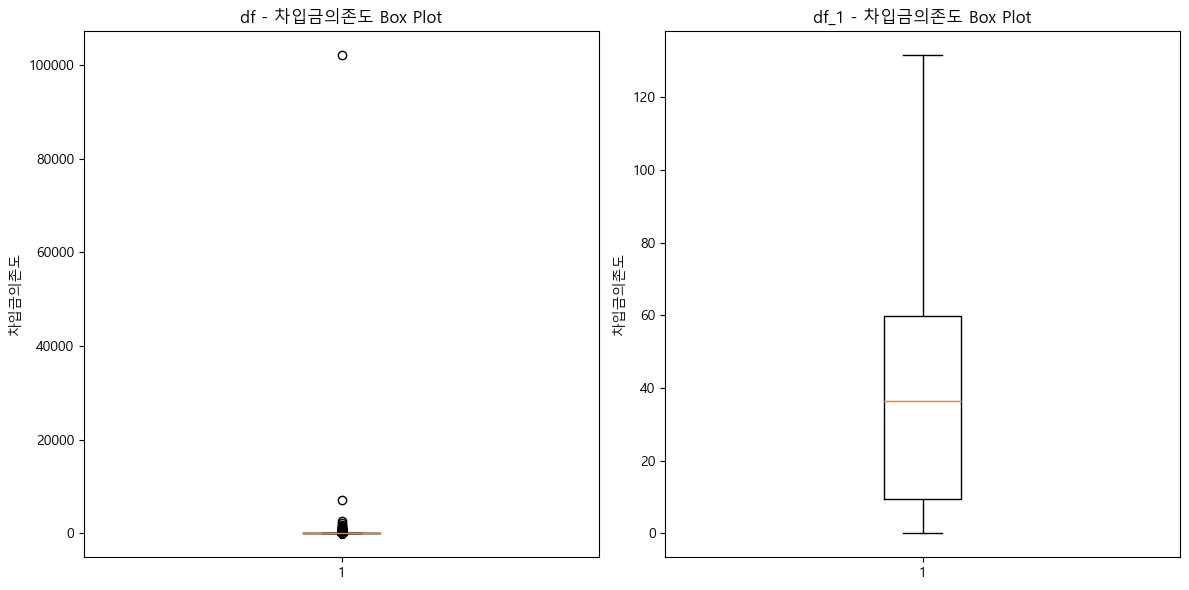

In [301]:
train_data_new= train_data.copy()

train_data_new['차입금의존도'] = winsorize(train_data_new['차입금의존도'], limits= (0, 0.005))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['차입금의존도'].dropna())
axes[0].set_title('df - 차입금의존도 Box Plot')
axes[0].set_ylabel('차입금의존도')

# df_1['차입금의존도']의 박스플롯
axes[1].boxplot(train_data_new['차입금의존도'].dropna())
axes[1].set_title('df_1 - 차입금의존도 Box Plot')
axes[1].set_ylabel('차입금의존도')

# 그래프 간격 조정
plt.tight_layout()

# 그래프 

- 매출액영업이익률

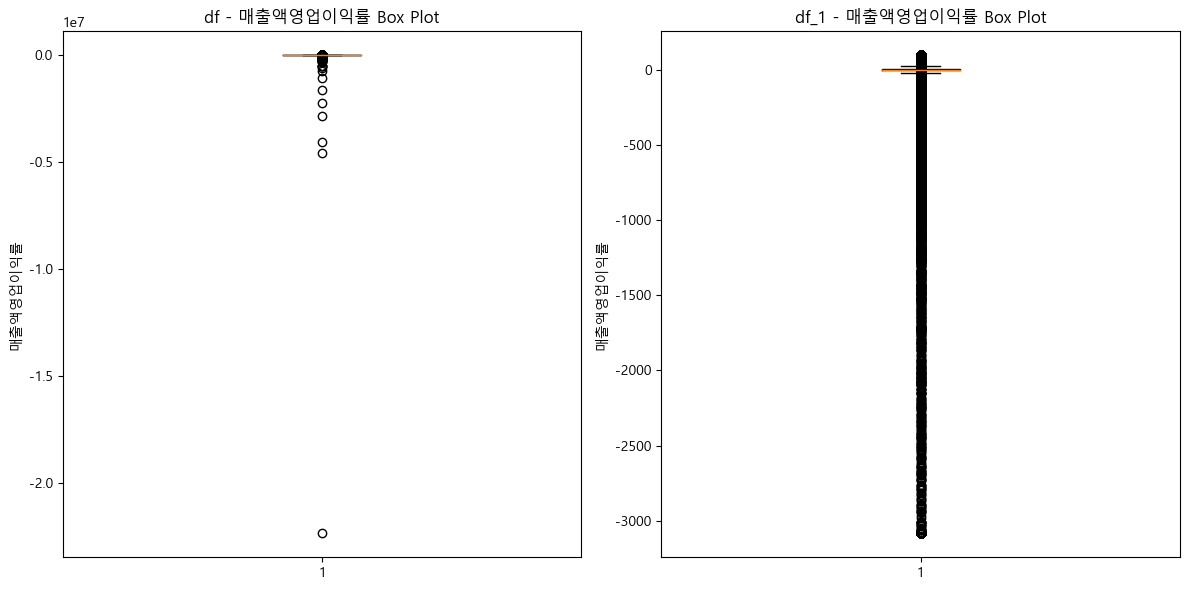

In [302]:
train_data_new= train_data.copy()

train_data_new['매출액영업이익률'] = winsorize(train_data_new['매출액영업이익률'], limits= (0.0045,0.0005 ))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['매출액영업이익률'].dropna())
axes[0].set_title('df - 매출액영업이익률 Box Plot')
axes[0].set_ylabel('매출액영업이익률')

# df_1['매출액영업이익률']의 박스플롯
axes[1].boxplot(train_data_new['매출액영업이익률'].dropna())
axes[1].set_title('df_1 - 매출액영업이익률 Box Plot')
axes[1].set_ylabel('매출액영업이익률')

# 그래프 간격 조정
plt.tight_layout()

# 그래프 

- 자기자본순이익률

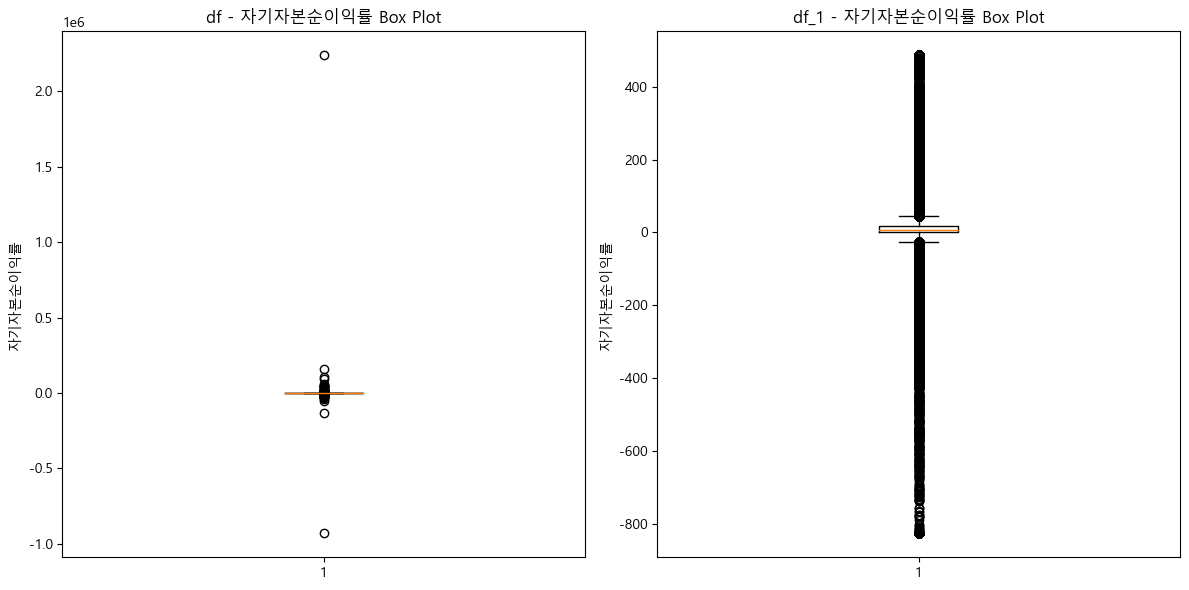

In [303]:
train_data_new= train_data.copy()

train_data_new['자기자본순이익률'] = winsorize(train_data_new['자기자본순이익률'], limits= (0.002, 0.003))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['자기자본순이익률'].dropna())
axes[0].set_title('df - 자기자본순이익률 Box Plot')
axes[0].set_ylabel('자기자본순이익률')

# df_1['자기자본순이익률']의 박스플롯
axes[1].boxplot(train_data_new['자기자본순이익률'].dropna())
axes[1].set_title('df_1 - 자기자본순이익률 Box Plot')
axes[1].set_ylabel('자기자본순이익률')

# 그래프 간격 조정
plt.tight_layout()

# 그래프 

- 총자본순이익률

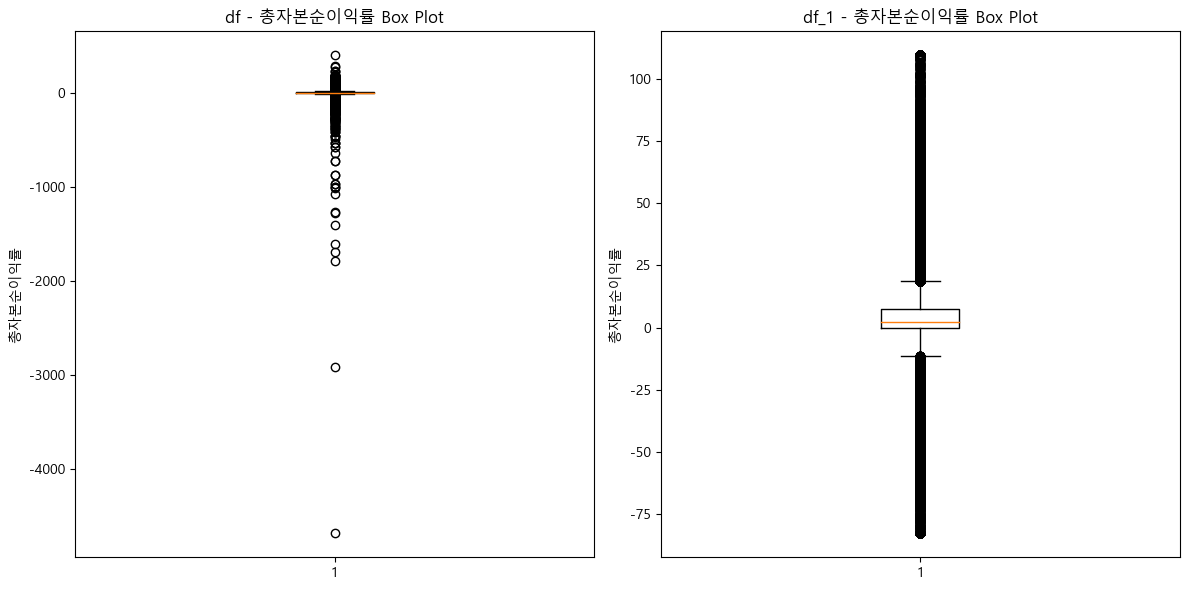

In [304]:
train_data_new= train_data.copy()

train_data_new['총자본순이익률'] = winsorize(train_data_new['총자본순이익률'], limits= (0.0035, 0.0015))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['총자본순이익률'].dropna())
axes[0].set_title('df - 총자본순이익률 Box Plot')
axes[0].set_ylabel('총자본순이익률')

# df_1['총자본순이익률']의 박스플롯
axes[1].boxplot(train_data_new['총자본순이익률'].dropna())
axes[1].set_title('df_1 - 총자본순이익률 Box Plot')
axes[1].set_ylabel('총자본순이익률')

# 그래프 간격 조정
plt.tight_layout()

# 그래프 

- 총자본회전률

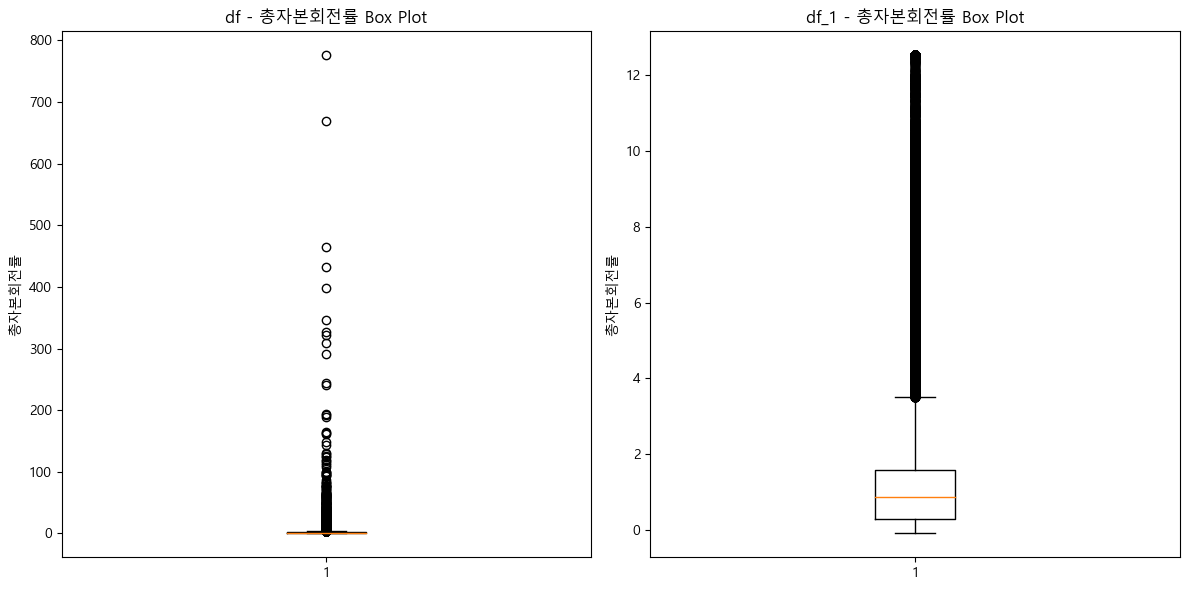

In [305]:
train_data_new= train_data.copy()

train_data_new['총자본회전률'] = winsorize(train_data_new['총자본회전률'], limits= (0, 0.005))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['총자본회전률'].dropna())
axes[0].set_title('df - 총자본회전률 Box Plot')
axes[0].set_ylabel('총자본회전률')

# df_1['총자본회전률']의 박스플롯
axes[1].boxplot(train_data_new['총자본회전률'].dropna())
axes[1].set_title('df_1 - 총자본회전률 Box Plot')
axes[1].set_ylabel('총자본회전률')

# 그래프 간격 조정
plt.tight_layout()

# 그래프 

- 자기자본회전률

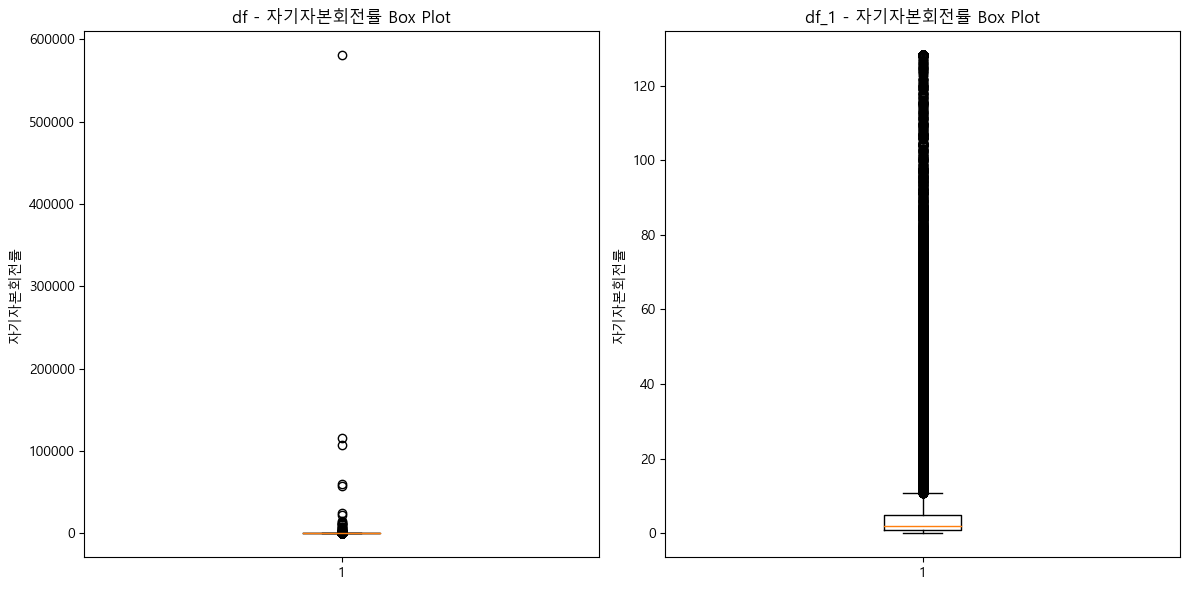

In [306]:
train_data_new= train_data.copy()

train_data_new['자기자본회전률'] = winsorize(train_data_new['자기자본회전률'], limits= (0, 0.005))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['자기자본회전률'].dropna())
axes[0].set_title('df - 자기자본회전률 Box Plot')
axes[0].set_ylabel('자기자본회전률')

# df_1['자기자본회전률']의 박스플롯
axes[1].boxplot(train_data_new['자기자본회전률'].dropna())
axes[1].set_title('df_1 - 자기자본회전률 Box Plot')
axes[1].set_ylabel('자기자본회전률')

# 그래프 간격 조정
plt.tight_layout()

# 그래프 

- 운전자본회전률

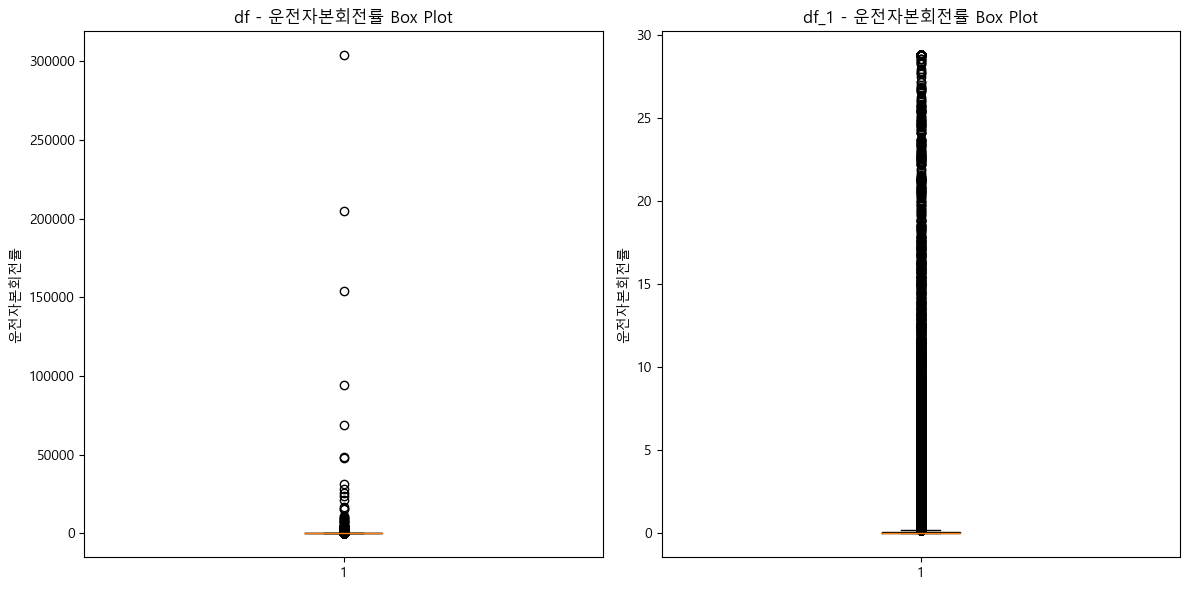

In [307]:
train_data_new= train_data.copy()

train_data_new['운전자본회전률'] = winsorize(train_data_new['운전자본회전률'], limits= (0, 0.005))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['운전자본회전률'].dropna())
axes[0].set_title('df - 운전자본회전률 Box Plot')
axes[0].set_ylabel('운전자본회전률')

# df_1['운전자본회전률']의 박스플롯
axes[1].boxplot(train_data_new['운전자본회전률'].dropna())
axes[1].set_title('df_1 - 운전자본회전률 Box Plot')
axes[1].set_ylabel('운전자본회전률')

# 그래프 간격 조정
plt.tight_layout()

# 그래프 

- 순운전자본회전률

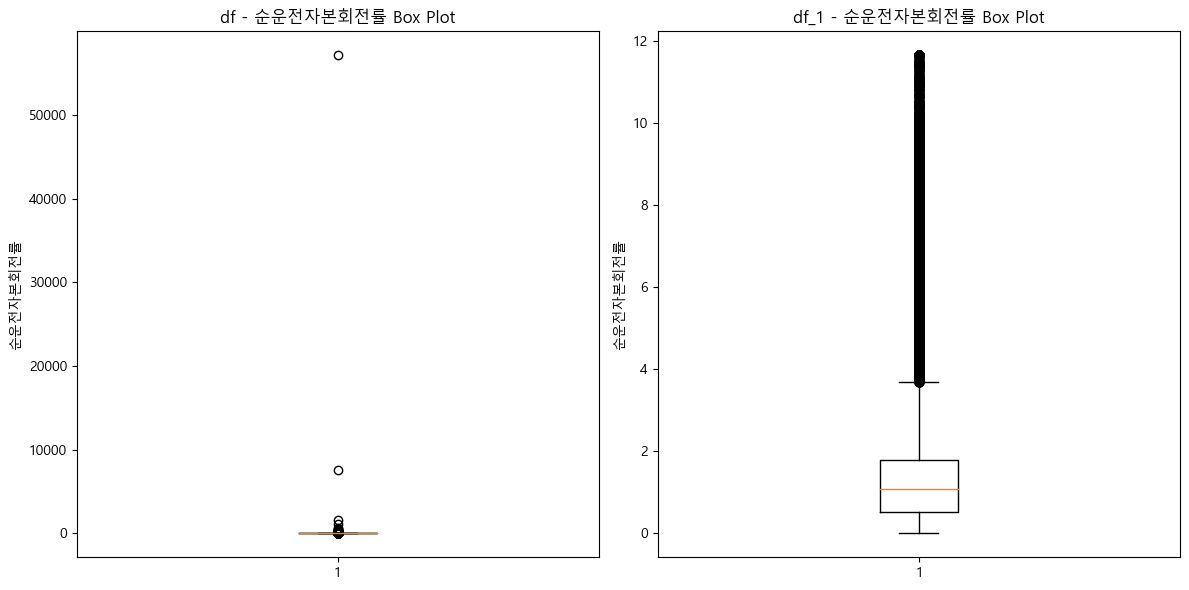

In [308]:
train_data_new= train_data.copy()

train_data_new['순운전자본회전률'] = winsorize(train_data_new['순운전자본회전률'], limits= (0.00001, 0.00499))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['순운전자본회전률'].dropna())
axes[0].set_title('df - 순운전자본회전률 Box Plot')
axes[0].set_ylabel('순운전자본회전률')

# df_1['순운전자본회전률']의 박스플롯
axes[1].boxplot(train_data_new['순운전자본회전률'].dropna())
axes[1].set_title('df_1 - 순운전자본회전률 Box Plot')
axes[1].set_ylabel('순운전자본회전률')

# 그래프 간격 조정
plt.tight_layout()

- 재고자산회전률

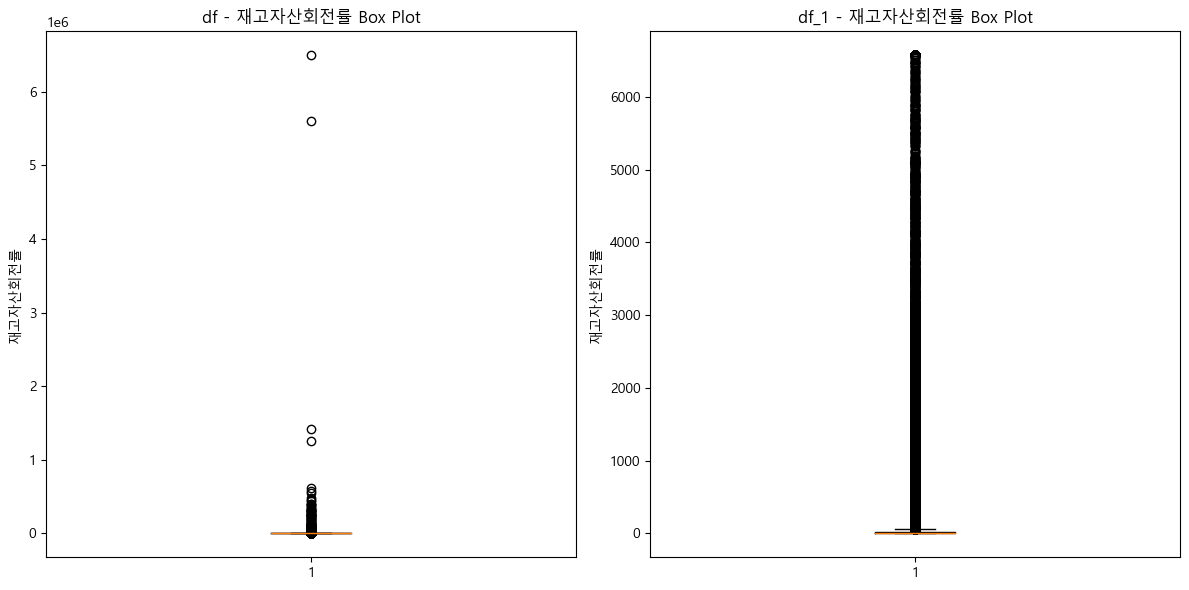

In [309]:
train_data_new= train_data.copy()

train_data_new['재고자산회전률'] = winsorize(train_data_new['재고자산회전률'], limits= (0, 0.005))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['재고자산회전률'].dropna())
axes[0].set_title('df - 재고자산회전률 Box Plot')
axes[0].set_ylabel('재고자산회전률')

# df_1['재고자산회전률']의 박스플롯
axes[1].boxplot(train_data_new['재고자산회전률'].dropna())
axes[1].set_title('df_1 - 재고자산회전률 Box Plot')
axes[1].set_ylabel('재고자산회전률')

# 그래프 간격 조정
plt.tight_layout()

- 당좌자산회전률

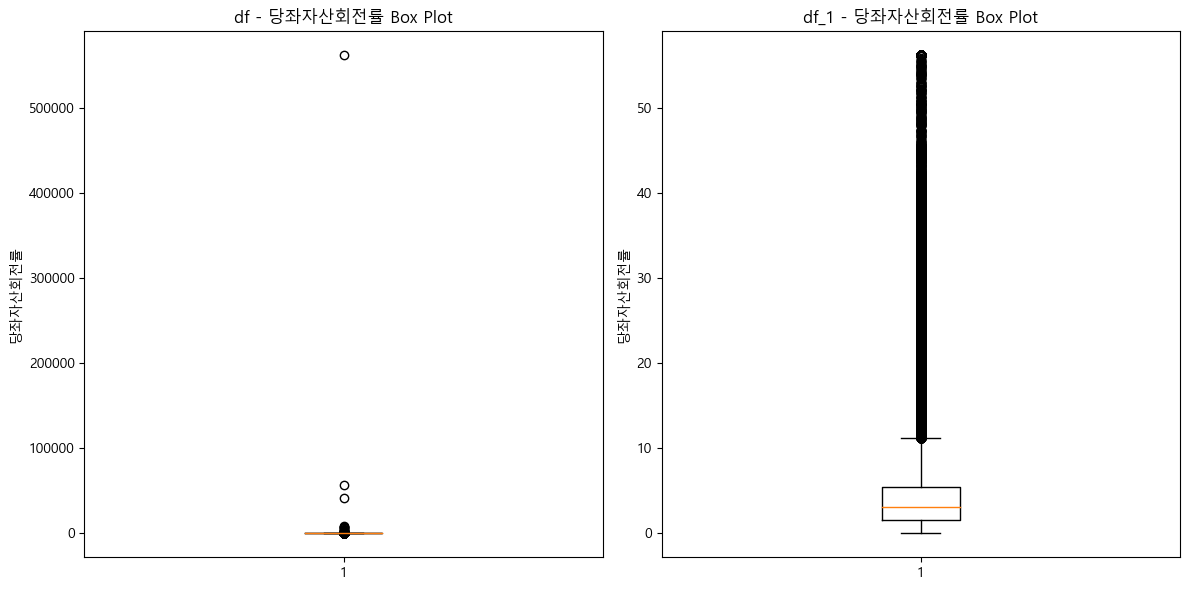

In [310]:
train_data_new= train_data.copy()

train_data_new['당좌자산회전률'] = winsorize(train_data_new['당좌자산회전률'], limits= (0.00001, 0.00499))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['당좌자산회전률'].dropna())
axes[0].set_title('df - 당좌자산회전률 Box Plot')
axes[0].set_ylabel('당좌자산회전률')

# df_1['당좌자산회전률']의 박스플롯
axes[1].boxplot(train_data_new['당좌자산회전률'].dropna())
axes[1].set_title('df_1 - 당좌자산회전률 Box Plot')
axes[1].set_ylabel('당좌자산회전률')

# 그래프 간격 조정
plt.tight_layout()

- 유동자산회전률

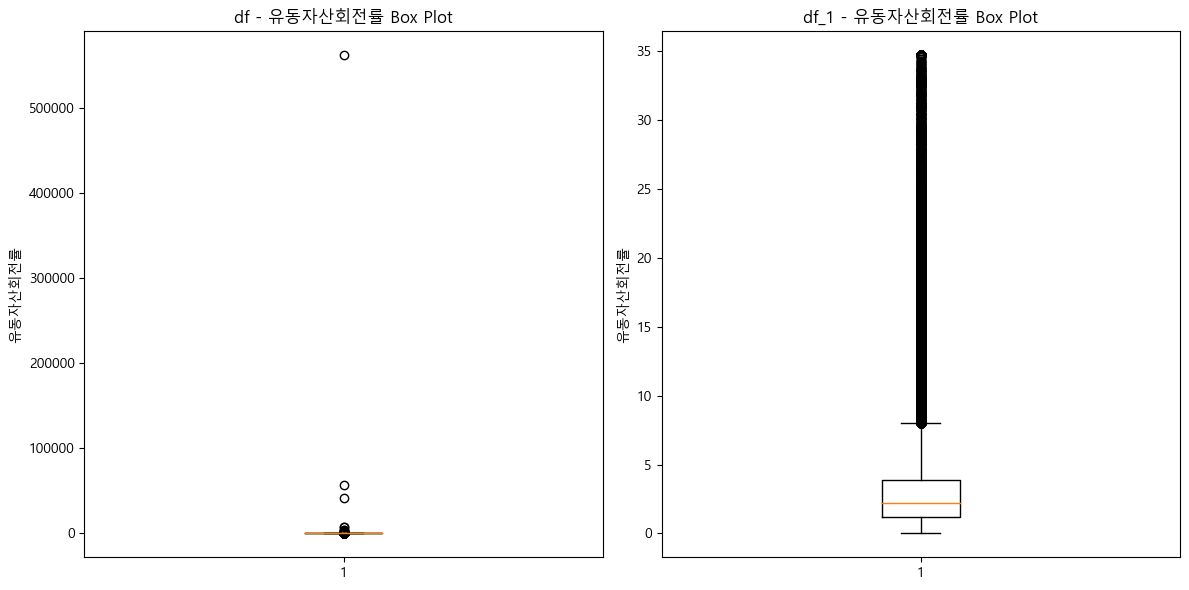

In [311]:
train_data_new= train_data.copy()

train_data_new['유동자산회전률'] = winsorize(train_data_new['유동자산회전률'], limits= (0.00001, 0.00499))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['유동자산회전률'].dropna())
axes[0].set_title('df - 유동자산회전률 Box Plot')
axes[0].set_ylabel('유동자산회전률')

# df_1['유동자산회전률']의 박스플롯
axes[1].boxplot(train_data_new['유동자산회전률'].dropna())
axes[1].set_title('df_1 - 유동자산회전률 Box Plot')
axes[1].set_ylabel('유동자산회전률')

# 그래프 간격 조정
plt.tight_layout()

- 매출액증가율

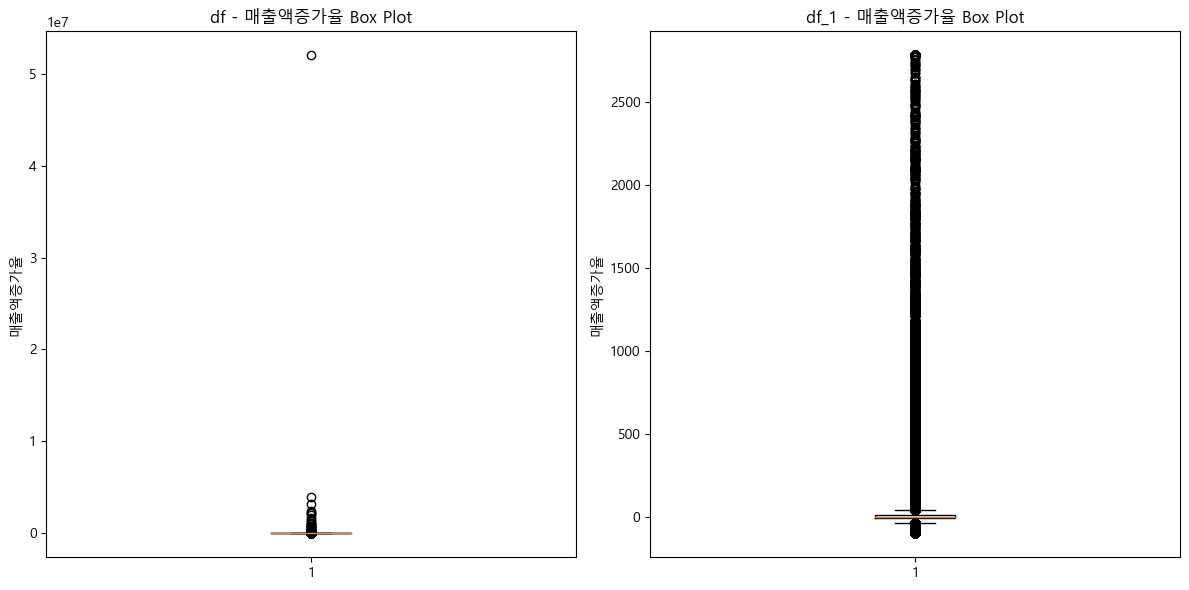

In [312]:
train_data_new= train_data.copy()

train_data_new['매출액증가율'] = winsorize(train_data_new['매출액증가율'], limits= (0.0001, 0.0049))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['매출액증가율'].dropna())
axes[0].set_title('df - 매출액증가율 Box Plot')
axes[0].set_ylabel('매출액증가율')

# df_1['매출액증가율']의 박스플롯
axes[1].boxplot(train_data_new['매출액증가율'].dropna())
axes[1].set_title('df_1 - 매출액증가율 Box Plot')
axes[1].set_ylabel('매출액증가율')

# 그래프 간격 조정
plt.tight_layout()

- 총자본증가율

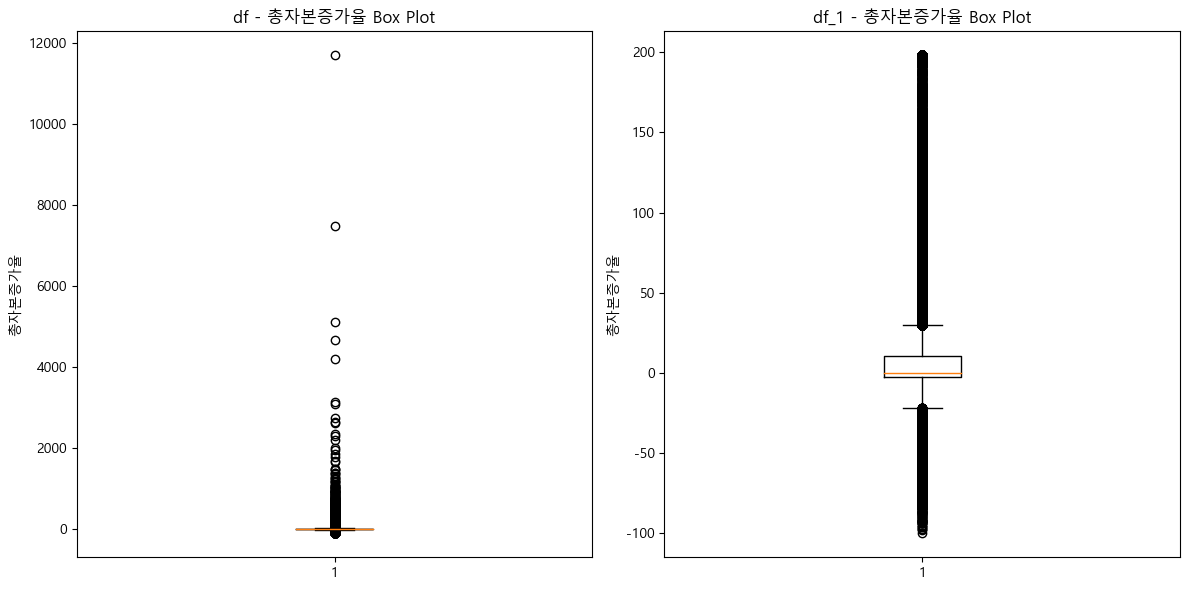

In [313]:
train_data_new= train_data.copy()

train_data_new['총자본증가율'] = winsorize(train_data_new['총자본증가율'], limits= (0, 0.005))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['총자본증가율'].dropna())
axes[0].set_title('df - 총자본증가율 Box Plot')
axes[0].set_ylabel('총자본증가율')

# df_1['총자본증가율']의 박스플롯
axes[1].boxplot(train_data_new['총자본증가율'].dropna())
axes[1].set_title('df_1 - 총자본증가율 Box Plot')
axes[1].set_ylabel('총자본증가율')

# 그래프 간격 조정
plt.tight_layout()

- 자기자본증가율

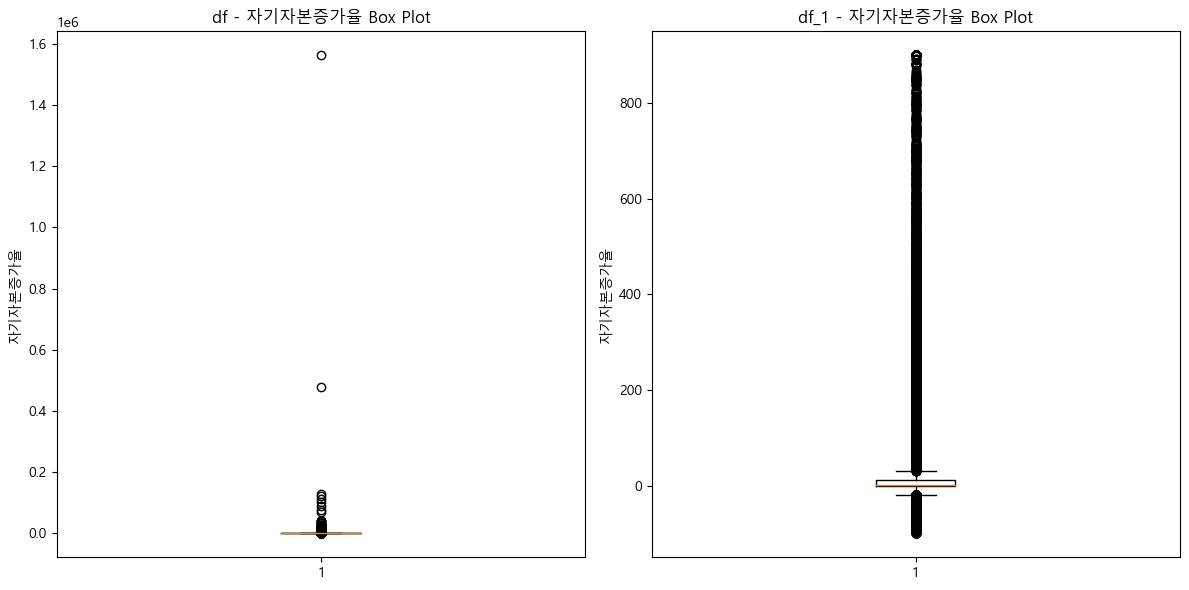

In [314]:
train_data_new= train_data.copy()

train_data_new['자기자본증가율'] = winsorize(train_data_new['자기자본증가율'], limits= (0.00001, 0.00499))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['자기자본증가율'].dropna())
axes[0].set_title('df - 자기자본증가율 Box Plot')
axes[0].set_ylabel('자기자본증가율')

# df_1['자기자본증가율']의 박스플롯
axes[1].boxplot(train_data_new['자기자본증가율'].dropna())
axes[1].set_title('df_1 - 자기자본증가율 Box Plot')
axes[1].set_ylabel('자기자본증가율')

# 그래프 간격 조정
plt.tight_layout()

- 순이익증가율

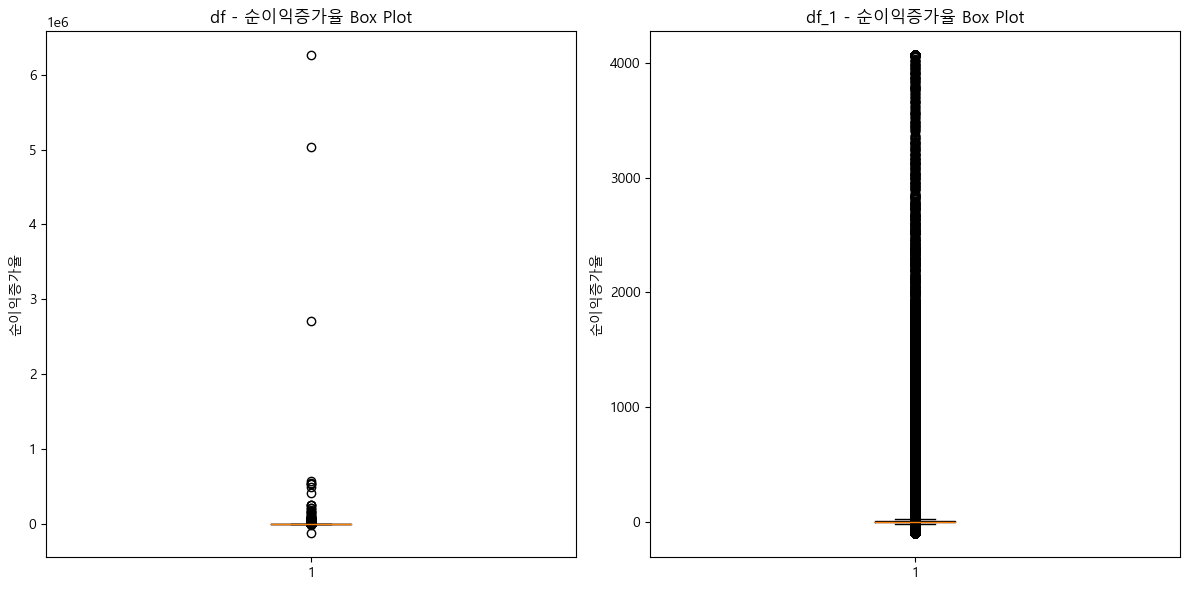

In [315]:
train_data_new= train_data.copy()

train_data_new['순이익증가율'] = winsorize(train_data_new['순이익증가율'], limits= (0.001, 0.004))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['순이익증가율'].dropna())
axes[0].set_title('df - 순이익증가율 Box Plot')
axes[0].set_ylabel('순이익증가율')

# df_1['순이익증가율']의 박스플롯
axes[1].boxplot(train_data_new['순이익증가율'].dropna())
axes[1].set_title('df_1 - 순이익증가율 Box Plot')
axes[1].set_ylabel('순이익증가율')

# 그래프 간격 조정
plt.tight_layout()

- 유형자산증가율

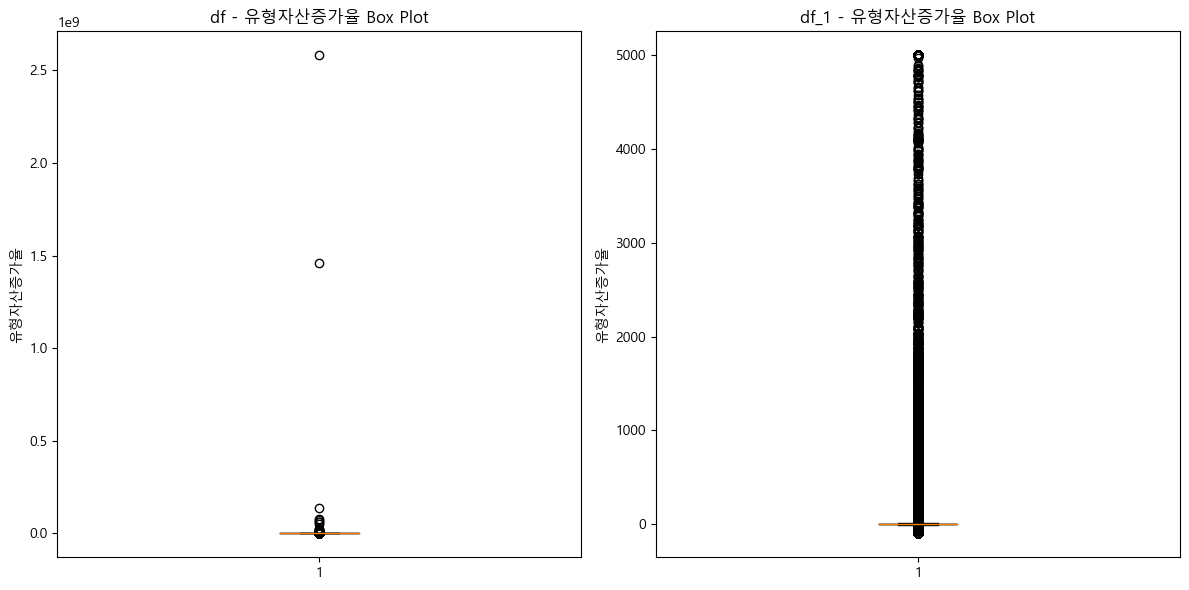

In [316]:
train_data_new= train_data.copy()

train_data_new['유형자산증가율'] = winsorize(train_data_new['유형자산증가율'], limits= (0, 0.005))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['유형자산증가율'].dropna())
axes[0].set_title('df - 유형자산증가율 Box Plot')
axes[0].set_ylabel('유형자산증가율')

# df_1['유형자산증가율']의 박스플롯
axes[1].boxplot(train_data_new['유형자산증가율'].dropna())
axes[1].set_title('df_1 - 유형자산증가율 Box Plot')
axes[1].set_ylabel('유형자산증가율')

# 그래프 간격 조정
plt.tight_layout()

- 유동자산증가율

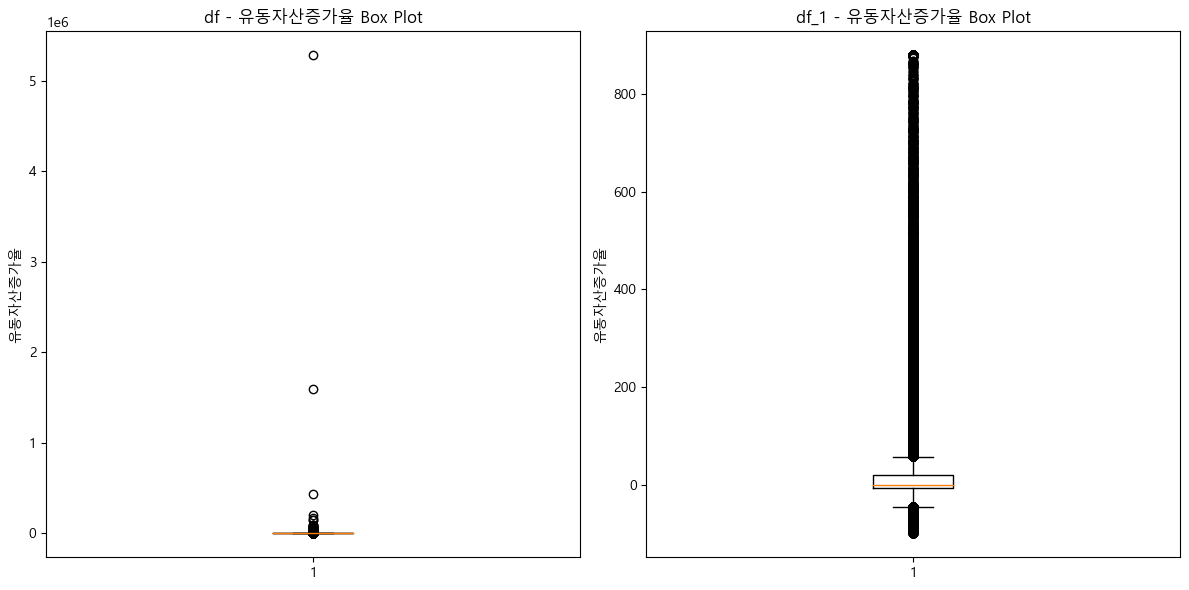

In [317]:
train_data_new= train_data.copy()

train_data_new['유동자산증가율'] = winsorize(train_data_new['유동자산증가율'], limits= (0, 0.005))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['유동자산증가율'].dropna())
axes[0].set_title('df - 유동자산증가율 Box Plot')
axes[0].set_ylabel('유동자산증가율')

# df_1['유동자산증가율']의 박스플롯
axes[1].boxplot(train_data_new['유동자산증가율'].dropna())
axes[1].set_title('df_1 - 유동자산증가율 Box Plot')
axes[1].set_ylabel('유동자산증가율')

# 그래프 간격 조정
plt.tight_layout()

- 재고자산증가율

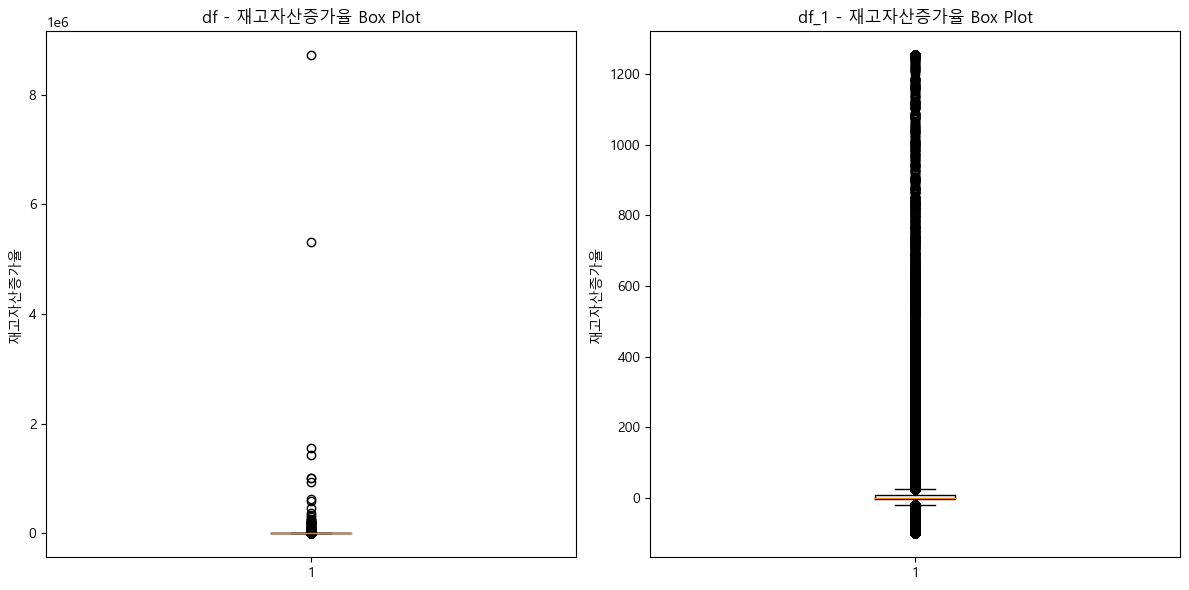

In [318]:
train_data_new= train_data.copy()

train_data_new['재고자산증가율'] = winsorize(train_data_new['재고자산증가율'], limits= (0, 0.005))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['재고자산증가율'].dropna())
axes[0].set_title('df - 재고자산증가율 Box Plot')
axes[0].set_ylabel('재고자산증가율')

# df_1['재고자산증가율']의 박스플롯
axes[1].boxplot(train_data_new['재고자산증가율'].dropna())
axes[1].set_title('df_1 - 재고자산증가율 Box Plot')
axes[1].set_ylabel('재고자산증가율')

# 그래프 간격 조정
plt.tight_layout()

- 영업이익증가율

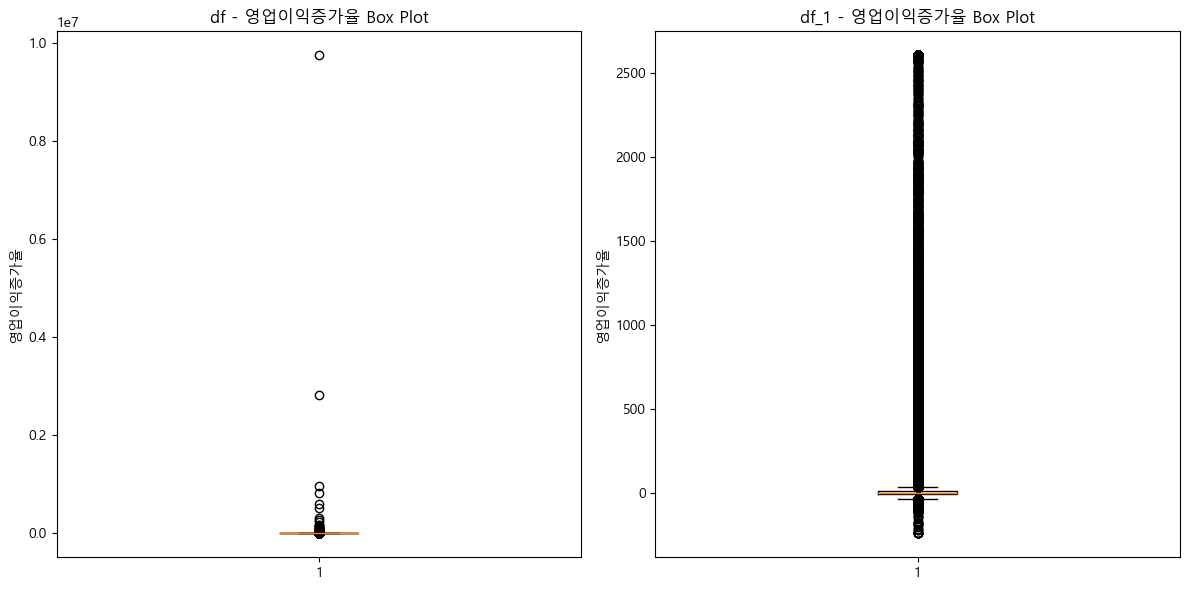

In [319]:
train_data_new= train_data.copy()

train_data_new['영업이익증가율'] = winsorize(train_data_new['영업이익증가율'], limits= (0.0001, 0.0049))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['영업이익증가율'].dropna())
axes[0].set_title('df - 영업이익증가율 Box Plot')
axes[0].set_ylabel('영업이익증가율')

# df_1['영업이익증가율']의 박스플롯
axes[1].boxplot(train_data_new['영업이익증가율'].dropna())
axes[1].set_title('df_1 - 영업이익증가율 Box Plot')
axes[1].set_ylabel('영업이익증가율')

# 그래프 간격 조정
plt.tight_layout()

- 총자본투자효율

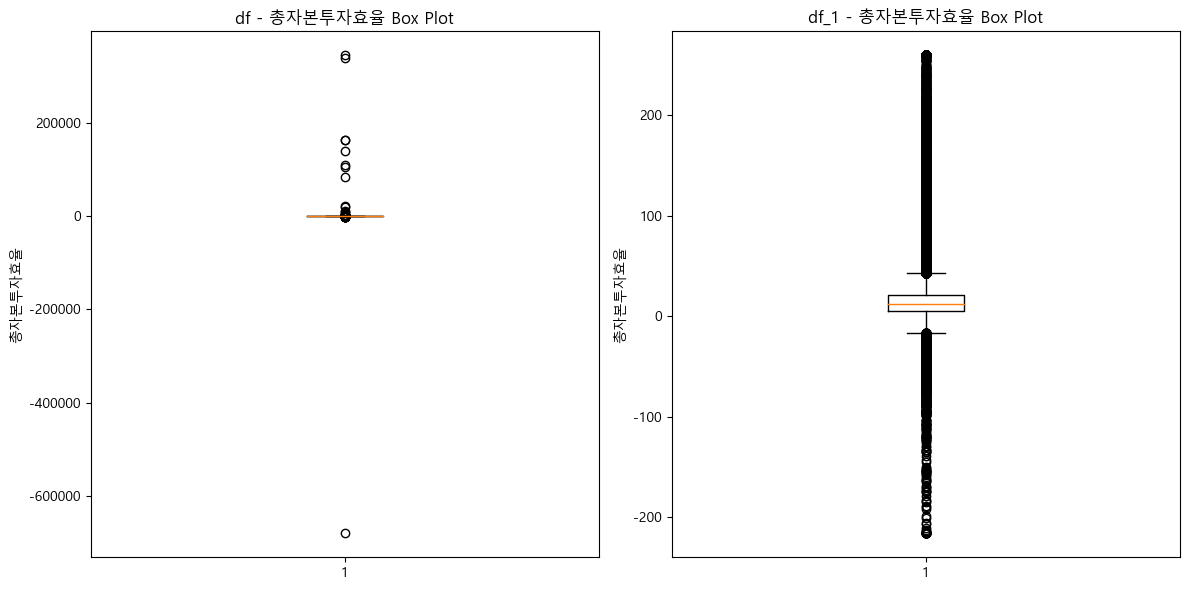

In [320]:
train_data_new= train_data.copy()

train_data_new['총자본투자효율'] = winsorize(train_data_new['총자본투자효율'], limits= (0.0003, 0.0047))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['총자본투자효율'].dropna())
axes[0].set_title('df - 총자본투자효율 Box Plot')
axes[0].set_ylabel('총자본투자효율')

# df_1['총자본투자효율']의 박스플롯
axes[1].boxplot(train_data_new['총자본투자효율'].dropna())
axes[1].set_title('df_1 - 총자본투자효율 Box Plot')
axes[1].set_ylabel('총자본투자효율')

# 그래프 간격 조정
plt.tight_layout()

- 부가가치율

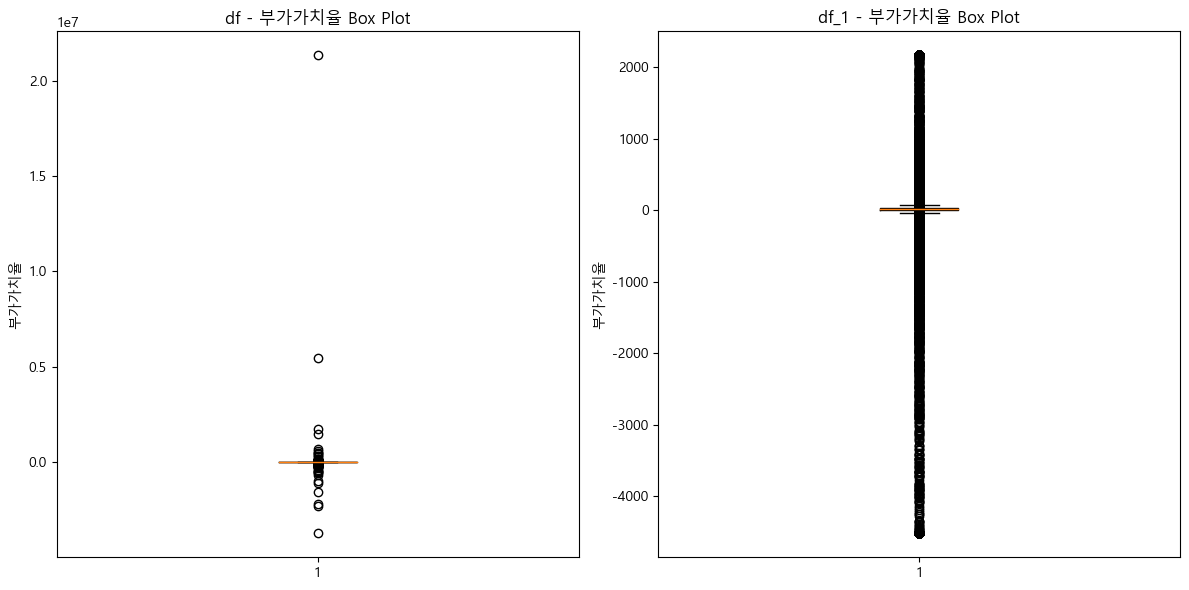

In [321]:
train_data_new= train_data.copy()

train_data_new['부가가치율'] = winsorize(train_data_new['부가가치율'], limits= (0.0025, 0.0025))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['부가가치율'].dropna())
axes[0].set_title('df - 부가가치율 Box Plot')
axes[0].set_ylabel('부가가치율')

# df_1['부가가치율']의 박스플롯
axes[1].boxplot(train_data_new['부가가치율'].dropna())
axes[1].set_title('df_1 - 부가가치율 Box Plot')
axes[1].set_ylabel('부가가치율')

# 그래프 간격 조정
plt.tight_layout()

- 노동소득분배율

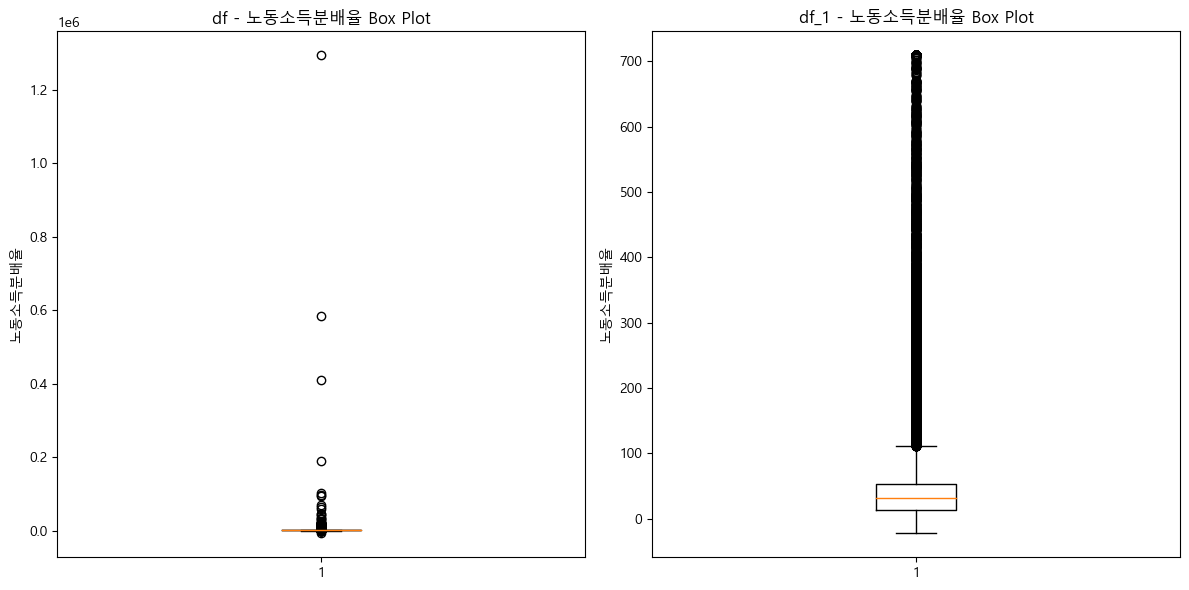

In [322]:
train_data_new= train_data.copy()

train_data_new['노동소득분배율'] = winsorize(train_data_new['노동소득분배율'], limits= (0.0001, 0.0049))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['노동소득분배율'].dropna())
axes[0].set_title('df - 노동소득분배율 Box Plot')
axes[0].set_ylabel('노동소득분배율')

# df_1['노동소득분배율']의 박스플롯
axes[1].boxplot(train_data_new['노동소득분배율'].dropna())
axes[1].set_title('df_1 - 노동소득분배율 Box Plot')
axes[1].set_ylabel('노동소득분배율')

# 그래프 간격 조정
plt.tight_layout()

- 자본분배율

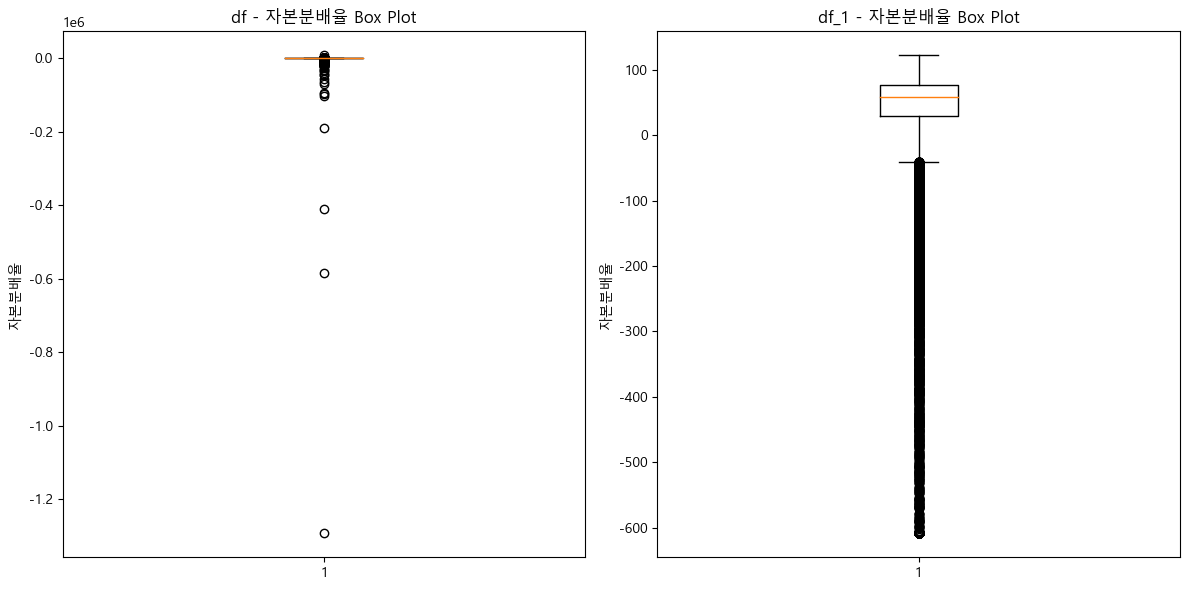

In [323]:
train_data_new= train_data.copy()

train_data_new['자본분배율'] = winsorize(train_data_new['자본분배율'], limits= (0.0049, 0.0001))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['자본분배율'].dropna())
axes[0].set_title('df - 자본분배율 Box Plot')
axes[0].set_ylabel('자본분배율')

# df_1['자본분배율']의 박스플롯
axes[1].boxplot(train_data_new['자본분배율'].dropna())
axes[1].set_title('df_1 - 자본분배율 Box Plot')
axes[1].set_ylabel('자본분배율')

# 그래프 간격 조정
plt.tight_layout()

- 이윤분배율

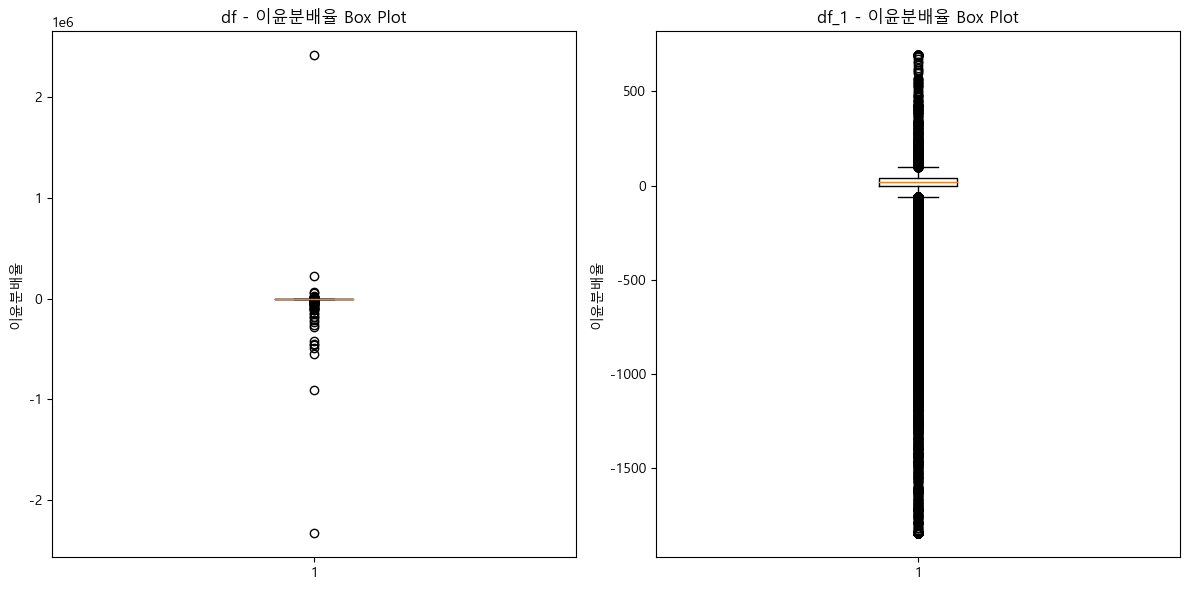

In [324]:
train_data_new= train_data.copy()

train_data_new['이윤분배율'] = winsorize(train_data_new['이윤분배율'], limits= (0.0045, 0.0005))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['이윤분배율'].dropna())
axes[0].set_title('df - 이윤분배율 Box Plot')
axes[0].set_ylabel('이윤분배율')

# df_1['이윤분배율']의 박스플롯
axes[1].boxplot(train_data_new['이윤분배율'].dropna())
axes[1].set_title('df_1 - 이윤분배율 Box Plot')
axes[1].set_ylabel('이윤분배율')

# 그래프 간격 조정
plt.tight_layout()

- OCF이자보상배율

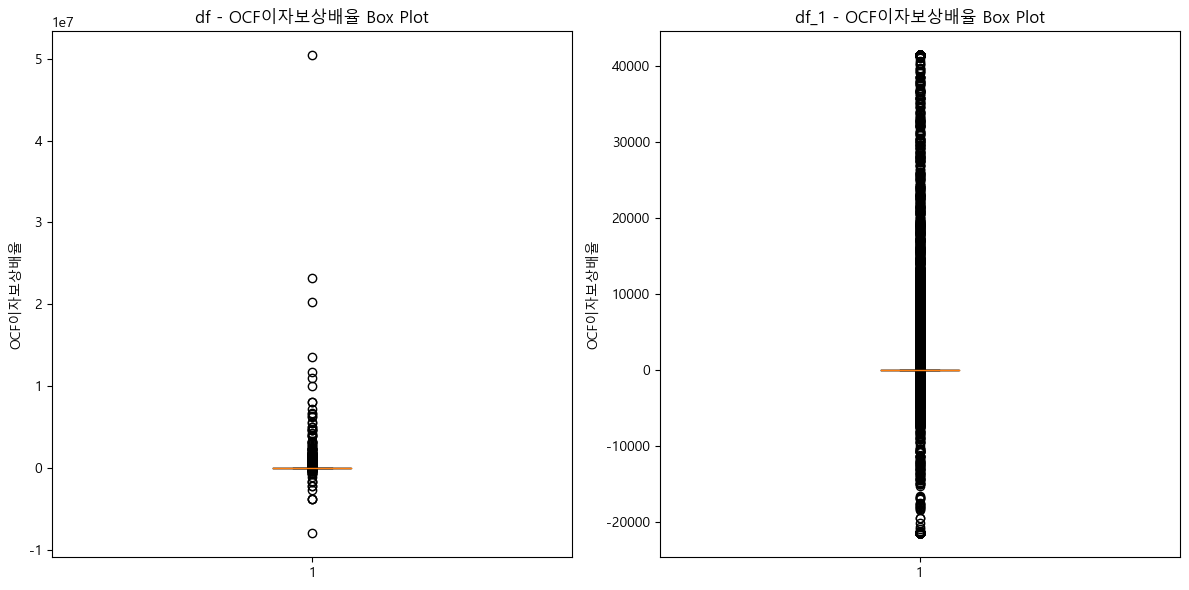

In [327]:
train_data_new= train_data.copy()

train_data_new['OCF이자보상배율'] = winsorize(train_data_new['OCF이자보상배율'], limits= (0.001, 0.004))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['OCF이자보상배율'].dropna())
axes[0].set_title('df - OCF이자보상배율 Box Plot')
axes[0].set_ylabel('OCF이자보상배율')

# df_1['OCF이자보상배율']의 박스플롯
axes[1].boxplot(train_data_new['OCF이자보상배율'].dropna())
axes[1].set_title('df_1 - OCF이자보상배율 Box Plot')
axes[1].set_ylabel('OCF이자보상배율')

# 그래프 간격 조정
plt.tight_layout()

- 부채상환계수

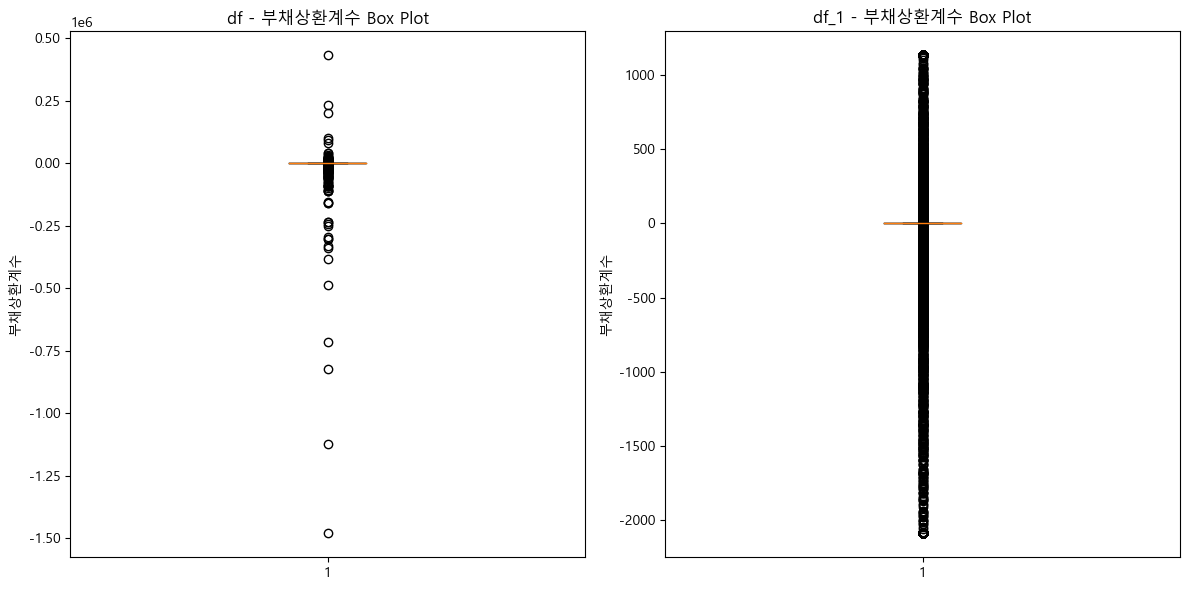

In [328]:
train_data_new= train_data.copy()

train_data_new['부채상환계수'] = winsorize(train_data_new['부채상환계수'], limits= (0.003, 0.002))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['부채상환계수'].dropna())
axes[0].set_title('df - 부채상환계수 Box Plot')
axes[0].set_ylabel('부채상환계수')

# df_1['부채상환계수']의 박스플롯
axes[1].boxplot(train_data_new['부채상환계수'].dropna())
axes[1].set_title('df_1 - 부채상환계수 Box Plot')
axes[1].set_ylabel('부채상환계수')

# 그래프 간격 조정
plt.tight_layout()

- 장기부채상환능력

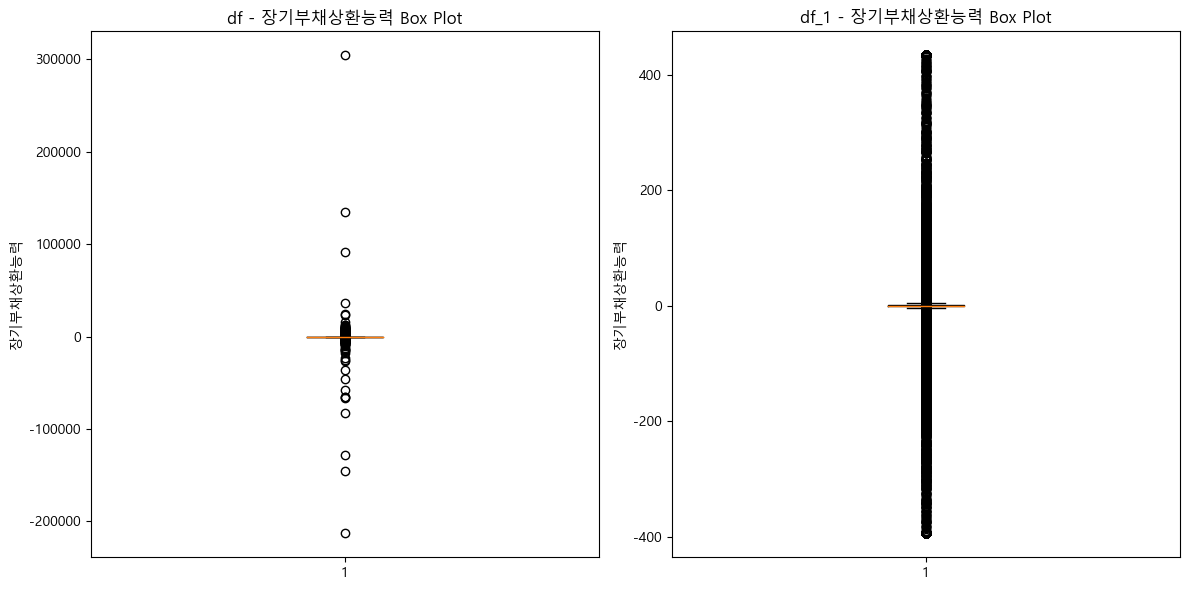

In [329]:
train_data_new= train_data.copy()

train_data_new['장기부채상환능력'] = winsorize(train_data_new['장기부채상환능력'], limits= (0.003, 0.002))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['장기부채상환능력'].dropna())
axes[0].set_title('df - 장기부채상환능력 Box Plot')
axes[0].set_ylabel('장기부채상환능력')

# df_1['장기부채상환능력']의 박스플롯
axes[1].boxplot(train_data_new['장기부채상환능력'].dropna())
axes[1].set_title('df_1 - 장기부채상환능력 Box Plot')
axes[1].set_ylabel('장기부채상환능력')

# 그래프 간격 조정
plt.tight_layout()

- 매출액대비금융비용상환능력

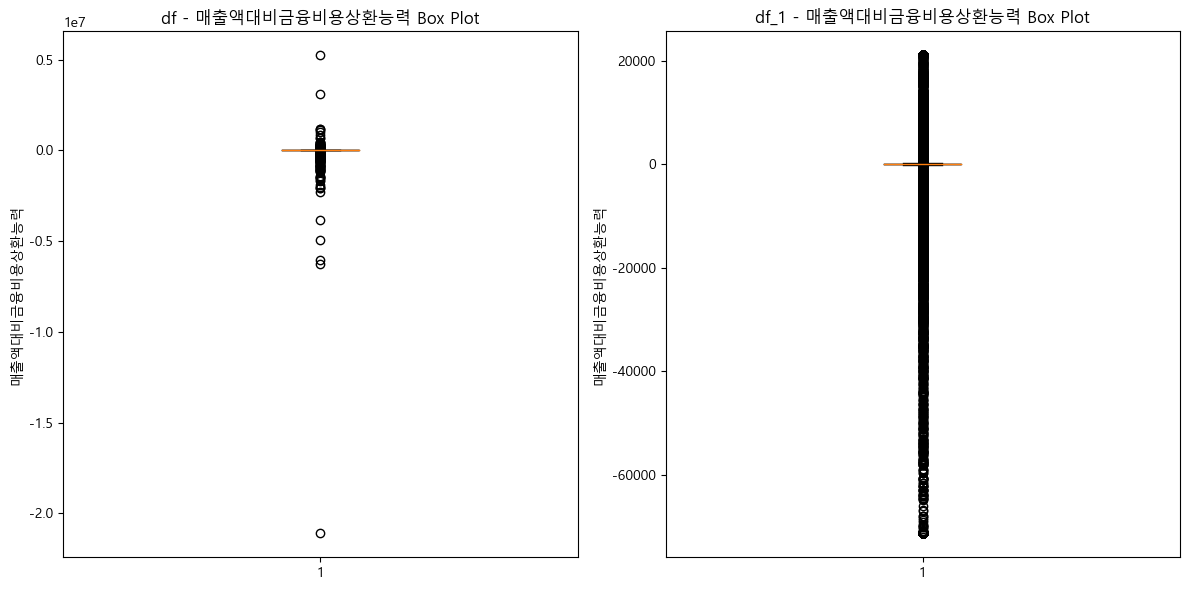

In [330]:
train_data_new= train_data.copy()

train_data_new['매출액대비금융비용상환능력'] = winsorize(train_data_new['매출액대비금융비용상환능력'], limits= (0.0025, 0.0025))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['매출액대비금융비용상환능력'].dropna())
axes[0].set_title('df - 매출액대비금융비용상환능력 Box Plot')
axes[0].set_ylabel('매출액대비금융비용상환능력')

# df_1['매출액대비금융비용상환능력']의 박스플롯
axes[1].boxplot(train_data_new['매출액대비금융비용상환능력'].dropna())
axes[1].set_title('df_1 - 매출액대비금융비용상환능력 Box Plot')
axes[1].set_ylabel('매출액대비금융비용상환능력')

# 그래프 간격 조정
plt.tight_layout()

- 연구개발비대비매출액

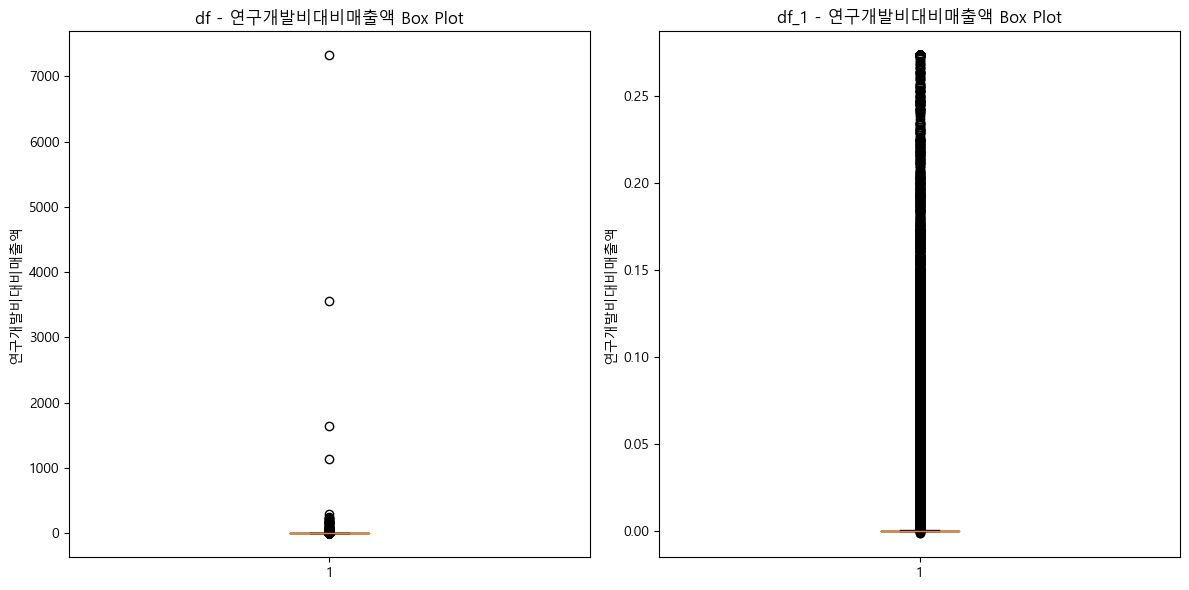

In [331]:
train_data_new= train_data.copy()

train_data_new['연구개발비대비매출액'] = winsorize(train_data_new['연구개발비대비매출액'], limits= (0, 0.005))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['연구개발비대비매출액'].dropna())
axes[0].set_title('df - 연구개발비대비매출액 Box Plot')
axes[0].set_ylabel('연구개발비대비매출액')

# df_1['연구개발비대비매출액']의 박스플롯
axes[1].boxplot(train_data_new['연구개발비대비매출액'].dropna())
axes[1].set_title('df_1 - 연구개발비대비매출액 Box Plot')
axes[1].set_ylabel('연구개발비대비매출액')

# 그래프 간격 조정
plt.tight_layout()

- 매출액대비현금흐름

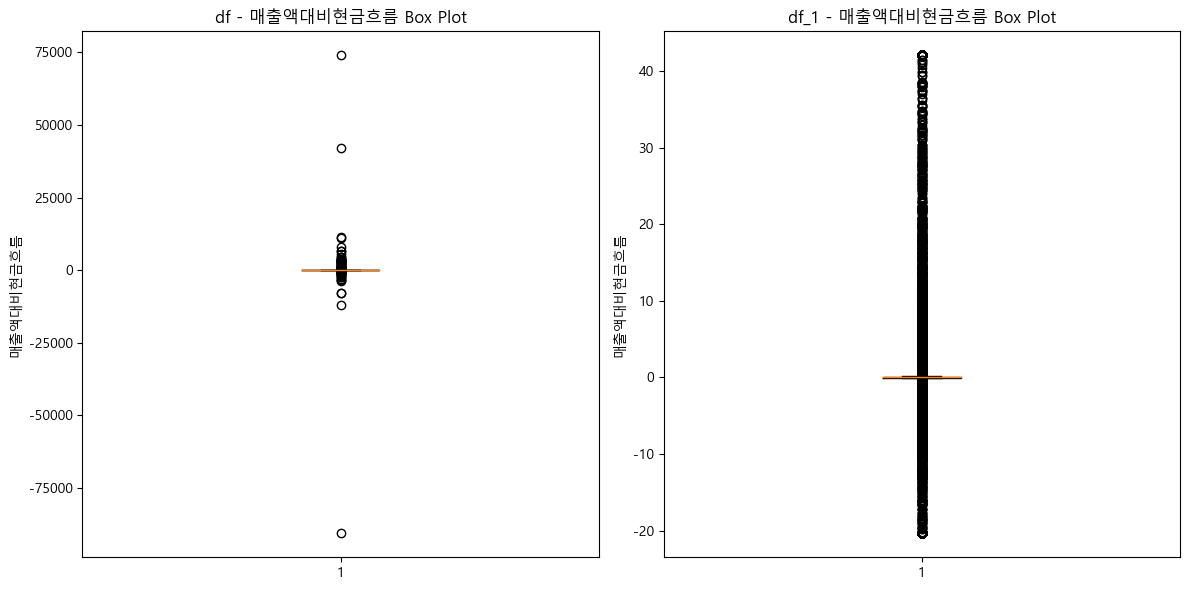

In [332]:
train_data_new= train_data.copy()

train_data_new['매출액대비현금흐름'] = winsorize(train_data_new['매출액대비현금흐름'], limits= (0.0025, 0.0025))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['매출액대비현금흐름'].dropna())
axes[0].set_title('df - 매출액대비현금흐름 Box Plot')
axes[0].set_ylabel('매출액대비현금흐름')

# df_1['매출액대비현금흐름']의 박스플롯
axes[1].boxplot(train_data_new['매출액대비현금흐름'].dropna())
axes[1].set_title('df_1 - 매출액대비현금흐름 Box Plot')
axes[1].set_ylabel('매출액대비현금흐름')

# 그래프 간격 조정
plt.tight_layout()

- 매출액대비잉여현금흐름

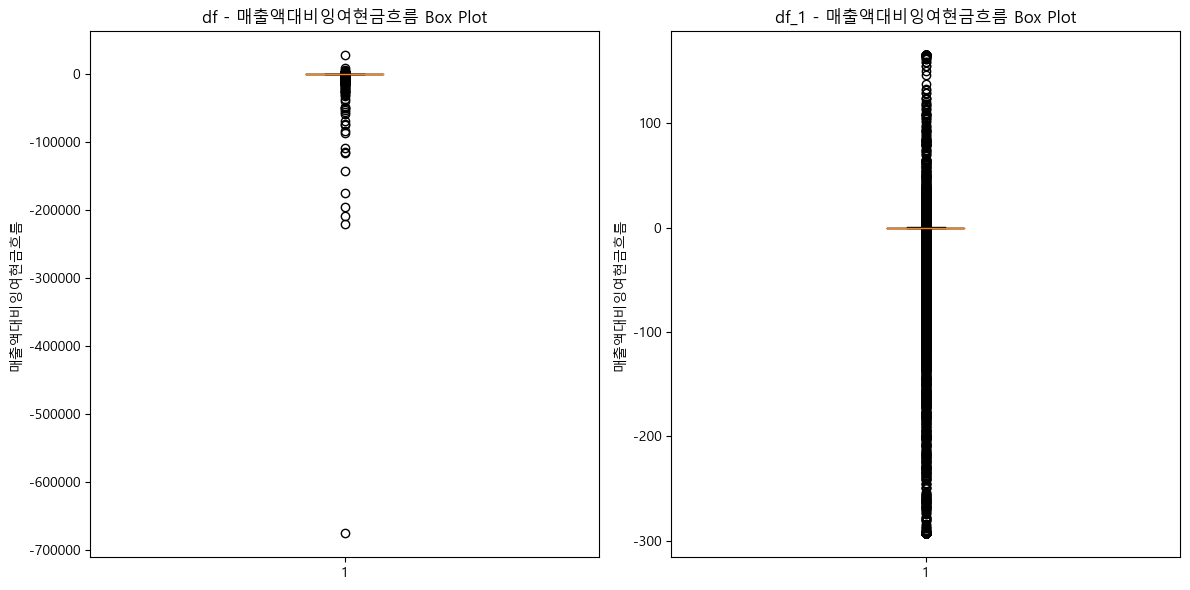

In [390]:
train_data_new= train_data.copy()

train_data_new['매출액대비잉여현금흐름'] = winsorize(train_data_new['매출액대비잉여현금흐름'], limits= (0.0045, 0.0005))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['매출액대비잉여현금흐름'].dropna())
axes[0].set_title('df - 매출액대비잉여현금흐름 Box Plot')
axes[0].set_ylabel('매출액대비잉여현금흐름')

# df_1['매출액대비잉여현금흐름']의 박스플롯
axes[1].boxplot(train_data_new['매출액대비잉여현금흐름'].dropna())
axes[1].set_title('df_1 - 매출액대비잉여현금흐름 Box Plot')
axes[1].set_ylabel('매출액대비잉여현금흐름')

# 그래프 간격 조정
plt.tight_layout()

- 총자산대비현금흐름

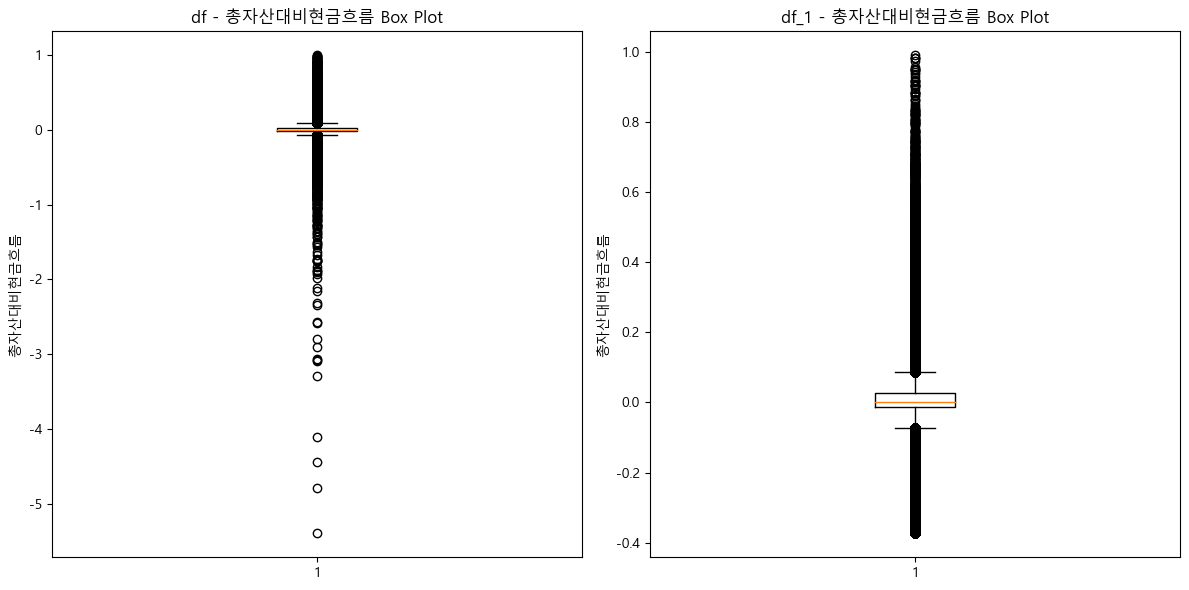

In [341]:
train_data_new= train_data.copy()

train_data_new['총자산대비현금흐름'] = winsorize(train_data_new['총자산대비현금흐름'], limits= (0.005, 0))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['총자산대비현금흐름'].dropna())
axes[0].set_title('df - 총자산대비현금흐름 Box Plot')
axes[0].set_ylabel('총자산대비현금흐름')

# df_1['총자산대비현금흐름']의 박스플롯
axes[1].boxplot(train_data_new['총자산대비현금흐름'].dropna())
axes[1].set_title('df_1 - 총자산대비현금흐름 Box Plot')
axes[1].set_ylabel('총자산대비현금흐름')

# 그래프 간격 조정
plt.tight_layout()

- 총자산대비현금흐름

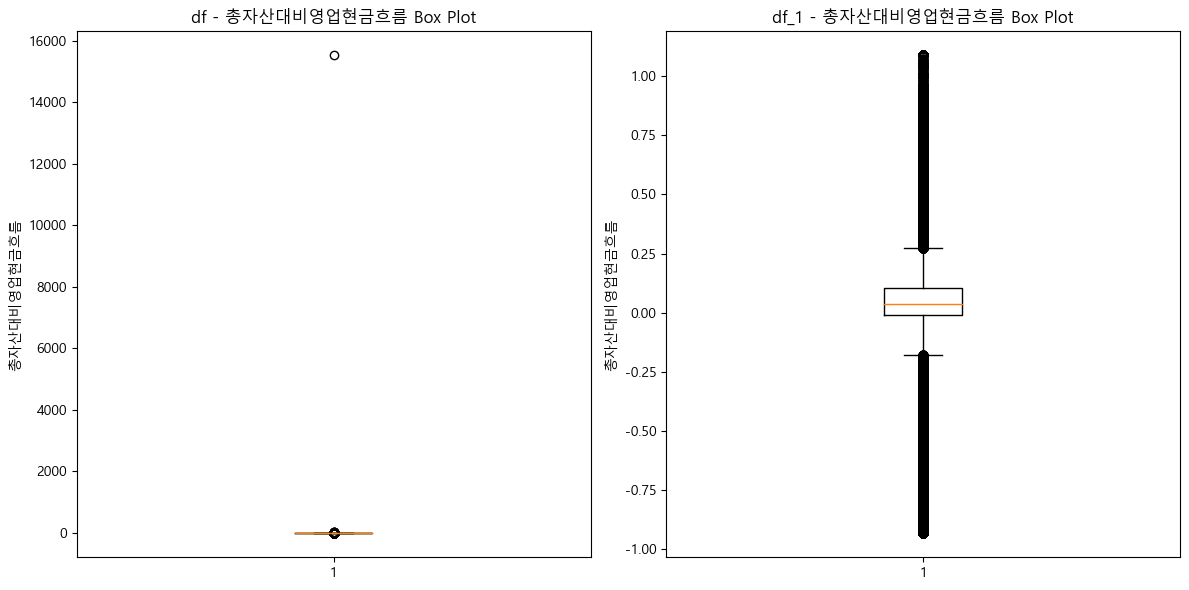

In [342]:
train_data_new= train_data.copy()

train_data_new['총자산대비영업현금흐름'] = winsorize(train_data_new['총자산대비영업현금흐름'], limits= (0.0025, 0.0025))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['총자산대비영업현금흐름'].dropna())
axes[0].set_title('df - 총자산대비영업현금흐름 Box Plot')
axes[0].set_ylabel('총자산대비영업현금흐름')

# df_1['총자산대비영업현금흐름']의 박스플롯
axes[1].boxplot(train_data_new['총자산대비영업현금흐름'].dropna())
axes[1].set_title('df_1 - 총자산대비영업현금흐름 Box Plot')
axes[1].set_ylabel('총자산대비영업현금흐름')

# 그래프 간격 조정
plt.tight_layout()

- 총자산대비잉여현금흐름

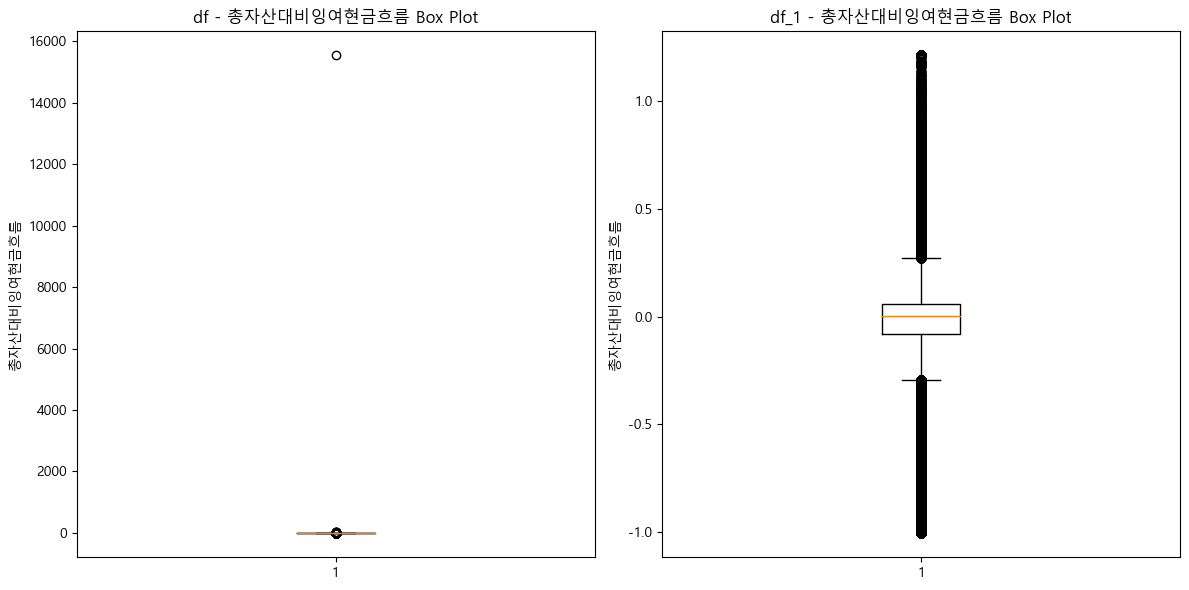

In [343]:
train_data_new= train_data.copy()

train_data_new['총자산대비잉여현금흐름'] = winsorize(train_data_new['총자산대비잉여현금흐름'], limits= (0.0025, 0.0025))  

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# df['자기자본비율']의 박스플롯
axes[0].boxplot(train_data['총자산대비잉여현금흐름'].dropna())
axes[0].set_title('df - 총자산대비잉여현금흐름 Box Plot')
axes[0].set_ylabel('총자산대비잉여현금흐름')

# df_1['총자산대비잉여현금흐름']의 박스플롯
axes[1].boxplot(train_data_new['총자산대비잉여현금흐름'].dropna())
axes[1].set_title('df_1 - 총자산대비잉여현금흐름 Box Plot')
axes[1].set_ylabel('총자산대비잉여현금흐름')

# 그래프 간격 조정
plt.tight_layout()

---

In [347]:
# train_data.to_csv('./Dataset/윈져전_train.csv',index=False, encoding='euc-kr')/

In [392]:
train_data = pd.read_csv('./Dataset/윈져전_train.csv',encoding='euc-kr')

In [393]:
train_data['부채비율'] = winsorize(train_data['부채비율'], limits= (0, 0.005))
train_data['당좌비율'] = winsorize(train_data['당좌비율'], limits= (0, 0.005)) 
train_data['유동비율'] = winsorize(train_data['유동비율'], limits= (0, 0.005)) 
train_data['이자보상배율'] = winsorize(train_data['이자보상배율'], limits= (0.001, 0.004)) 
train_data['차입금의존도'] = winsorize(train_data['차입금의존도'], limits= (0, 0.005))  
train_data['매출액영업이익률'] = winsorize(train_data['매출액영업이익률'], limits= (0.0045,0.0005 ))  
train_data['자기자본순이익률'] = winsorize(train_data['자기자본순이익률'], limits= (0.002, 0.003))  
train_data['총자본순이익률'] = winsorize(train_data['총자본순이익률'], limits= (0.0035, 0.0015))  
train_data['총자본회전률'] = winsorize(train_data['총자본회전률'], limits= (0, 0.005))  
train_data['자기자본회전률'] = winsorize(train_data['자기자본회전률'], limits= (0, 0.005))  
train_data['운전자본회전률'] = winsorize(train_data['운전자본회전률'], limits= (0, 0.005))  
train_data['순운전자본회전률'] = winsorize(train_data['순운전자본회전률'], limits= (0.00001, 0.00499))  
train_data['재고자산회전률'] = winsorize(train_data['재고자산회전률'], limits= (0, 0.005))  
train_data['당좌자산회전률'] = winsorize(train_data['당좌자산회전률'], limits= (0.00001, 0.00499))  
train_data['유동자산회전률'] = winsorize(train_data['유동자산회전률'], limits= (0.00001, 0.00499))  
train_data['매출액증가율'] = winsorize(train_data['매출액증가율'], limits= (0.0001, 0.0049))  
train_data['총자본증가율'] = winsorize(train_data['총자본증가율'], limits= (0, 0.005))  
train_data['자기자본증가율'] = winsorize(train_data['자기자본증가율'], limits= (0.00001, 0.00499))  
train_data['순이익증가율'] = winsorize(train_data['순이익증가율'], limits= (0.001, 0.004))  
train_data['유형자산증가율'] = winsorize(train_data['유형자산증가율'], limits= (0, 0.005))  
train_data['유동자산증가율'] = winsorize(train_data['유동자산증가율'], limits= (0, 0.005))  
train_data['재고자산증가율'] = winsorize(train_data['재고자산증가율'], limits= (0, 0.005))  
train_data['영업이익증가율'] = winsorize(train_data['영업이익증가율'], limits= (0.0001, 0.0049))  
train_data['총자본투자효율'] = winsorize(train_data['총자본투자효율'], limits= (0.0003, 0.0047))  
train_data['부가가치율'] = winsorize(train_data['부가가치율'], limits= (0.0025, 0.0025))  
train_data['노동소득분배율'] = winsorize(train_data['노동소득분배율'], limits= (0.0001, 0.0049))  
train_data['자본분배율'] = winsorize(train_data['자본분배율'], limits= (0.0049, 0.0001))  
train_data['이윤분배율'] = winsorize(train_data['이윤분배율'], limits= (0.0045, 0.0005))  
train_data['OCF이자보상배율'] = winsorize(train_data['OCF이자보상배율'], limits= (0.001, 0.004))  
train_data['부채상환계수'] = winsorize(train_data['부채상환계수'], limits= (0.003, 0.002))  
train_data['장기부채상환능력'] = winsorize(train_data['장기부채상환능력'], limits= (0.003, 0.002))  
train_data['매출액대비금융비용상환능력'] = winsorize(train_data['매출액대비금융비용상환능력'], limits= (0.0025, 0.0025))  
train_data['연구개발비대비매출액'] = winsorize(train_data['연구개발비대비매출액'], limits= (0, 0.005))  
train_data['매출액대비현금흐름'] = winsorize(train_data['매출액대비현금흐름'], limits= (0.0025, 0.0025))  
train_data['매출액대비잉여현금흐름'] = winsorize(train_data['매출액대비잉여현금흐름'], limits=(0.0045, 0.0005))
train_data['총자산대비현금흐름'] = winsorize(train_data['총자산대비현금흐름'], limits= (0.005, 0))  
train_data['총자산대비영업현금흐름'] = winsorize(train_data['총자산대비영업현금흐름'], limits= (0.0025, 0.0025))  
train_data['총자산대비잉여현금흐름'] = winsorize(train_data['총자산대비잉여현금흐름'], limits= (0.0025, 0.0025))  


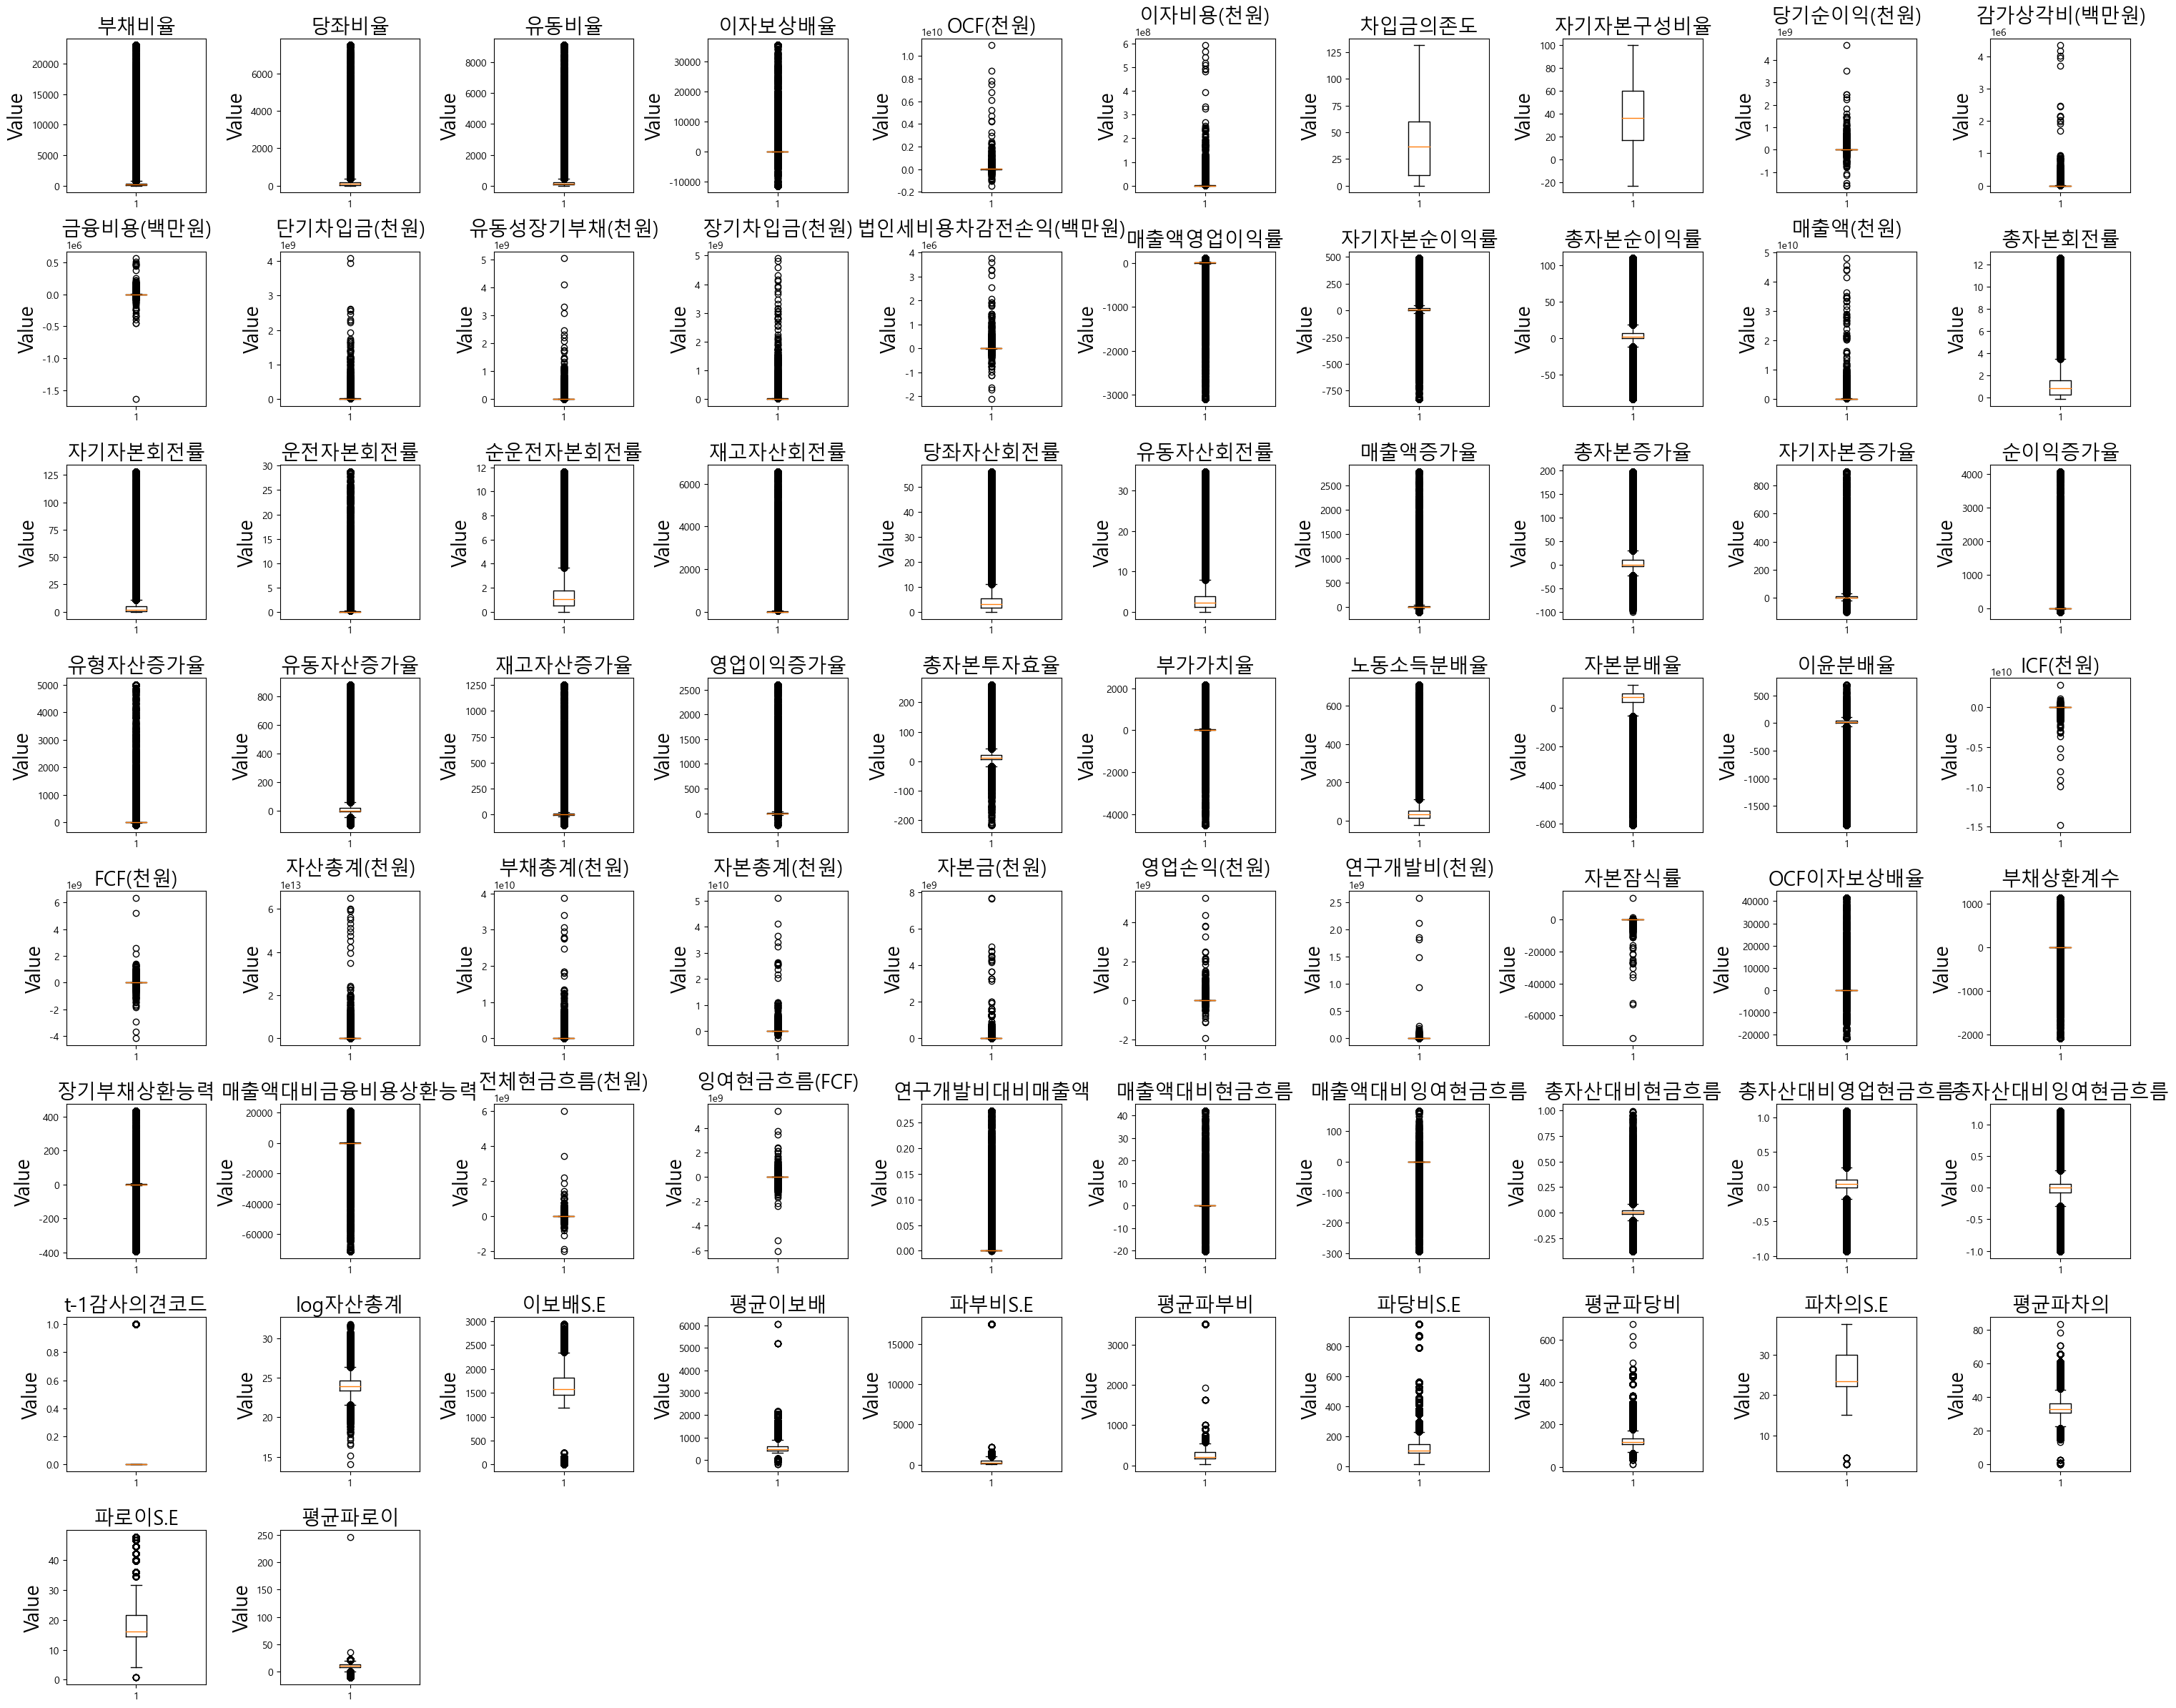

In [394]:
import matplotlib.pyplot as plt

df_수치_윈저라이징전 = train_data[train_data.select_dtypes(float).columns]
num_columns = len(df_수치_윈저라이징전.columns)

# 서브플롯의 크기 계산
nrows = (num_columns - 1) // 10 + 1
ncols = min(num_columns, 10)

# subplots로 boxplot 출력 (계산된 행과 열 개수로 서브플롯 그리기)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 24))

# 컬럼 개수에 따라 그려야 할 서브플롯의 개수만큼만 boxplot 그리기
for i, col in enumerate(df_수치_윈저라이징전):
    ax = axes[i // ncols, i % ncols]
    ax.boxplot(df_수치_윈저라이징전[col].dropna())
    ax.set_title(col, fontsize=20)  # 글씨 크기 설정
    ax.set_ylabel('Value', fontsize=20)  # 글씨 크기 설정

# 남은 서브플롯 삭제
for j in range(num_columns, nrows * ncols):
    fig.delaxes(axes.flatten()[j])  # 남은 서브플롯의 인덱스를 가져옴

plt.tight_layout()
plt.show()


In [395]:
train_data.columns

Index(['회사명', '거래소코드', '회계년도', 'Year', '산업분류코드', '산업분류', '부채비율', '당좌비율',
       '유동비율', '이자보상배율', 'OCF(천원)', '이자비용(천원)', '차입금의존도', '자기자본구성비율',
       '당기순이익(천원)', '감가상각비(백만원)', '금융비용(백만원)', '단기차입금(천원)', '유동성장기부채(천원)',
       '장기차입금(천원)', '법인세비용차감전손익(백만원)', '매출액영업이익률', '자기자본순이익률', '총자본순이익률',
       '매출액(천원)', '총자본회전률', '자기자본회전률', '운전자본회전률', '순운전자본회전률', '재고자산회전률',
       '당좌자산회전률', '유동자산회전률', '매출액증가율', '총자본증가율', '자기자본증가율', '순이익증가율',
       '유형자산증가율', '유동자산증가율', '재고자산증가율', '영업이익증가율', '총자본투자효율', '부가가치율',
       '노동소득분배율', '자본분배율', '이윤분배율', 'ICF(천원)', 'FCF(천원)', '자산총계(천원)',
       '부채총계(천원)', '자본총계(천원)', '자본금(천원)', '영업손익(천원)', '연구개발비(천원)', '자본잠식률',
       'OCF이자보상배율', '부채상환계수', '장기부채상환능력', '매출액대비금융비용상환능력', '전체현금흐름(천원)',
       '잉여현금흐름(FCF)', '연구개발비대비매출액', '매출액대비현금흐름', '매출액대비잉여현금흐름', '총자산대비현금흐름',
       '총자산대비영업현금흐름', '총자산대비잉여현금흐름', '기업수명주기', 't-1감사의견코드', 'log자산총계',
       '이보배S.E', '평균이보배', '이보배초과여부', '파부비S.E', '평균파부비', '파부비초과여부', '파당비S.E',
       '평균파당비', '파당비초과여부', '파차의S.E', '평균파차의', '파차의

In [396]:
train_data=train_data[['회사명', '거래소코드', 'Year', '부채비율', '당좌비율',
       '유동비율', '이자보상배율', '차입금의존도', '자기자본구성비율',
       '매출액영업이익률', '자기자본순이익률', '총자본순이익률', '총자본회전률', '자기자본회전률', '운전자본회전률', '순운전자본회전률', '재고자산회전률',
       '당좌자산회전률', '유동자산회전률', '매출액증가율', '총자본증가율', '자기자본증가율', '순이익증가율',
       '유형자산증가율', '유동자산증가율', '재고자산증가율', '영업이익증가율', '총자본투자효율', '부가가치율',
       '노동소득분배율', '자본분배율', '이윤분배율', 'OCF이자보상배율', '부채상환계수', '장기부채상환능력', '매출액대비금융비용상환능력',
       '연구개발비대비매출액', '매출액대비현금흐름', '매출액대비잉여현금흐름', '총자산대비현금흐름',
       '총자산대비영업현금흐름', '총자산대비잉여현금흐름', '기업수명주기','이보배초과여부',
       '파부비초과여부','파당비초과여부', '파차의초과여부', '파로이초과여부', 'log자산총계',
       't-1감사의견코드']]

In [400]:
test_data= test_data[['회사명', '거래소코드', 'Year', '부채비율', '당좌비율',
       '유동비율', '이자보상배율', '차입금의존도', '자기자본구성비율',
       '매출액영업이익률', '자기자본순이익률', '총자본순이익률', '총자본회전률', '자기자본회전률', '운전자본회전률', '순운전자본회전률', '재고자산회전률',
       '당좌자산회전률', '유동자산회전률', '매출액증가율', '총자본증가율', '자기자본증가율', '순이익증가율',
       '유형자산증가율', '유동자산증가율', '재고자산증가율', '영업이익증가율', '총자본투자효율', '부가가치율',
       '노동소득분배율', '자본분배율', '이윤분배율', 'OCF이자보상배율', '부채상환계수', '장기부채상환능력', '매출액대비금융비용상환능력',
       '연구개발비대비매출액', '매출액대비현금흐름', '매출액대비잉여현금흐름', '총자산대비현금흐름',
       '총자산대비영업현금흐름', '총자산대비잉여현금흐름', '기업수명주기','이보배초과여부',
       '파부비초과여부','파당비초과여부', '파차의초과여부', '파로이초과여부', 'log자산총계',
       't-1감사의견코드']]

In [401]:
len(test_data.columns)

50

In [403]:
# train_data.to_csv('./Dataset/train_Winsorization.csv',index=False,encoding='euc-kr')
# test_data.to_csv('./Dataset/test.csv',index=False,encoding='euc-kr')